In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from astropy.io import fits
from astropy.table import Table
from scipy.stats.stats import pearsonr
pd.set_option('display.max_columns', None)

The COMBO-17 dataset contains data collected by the Chandra Deep Field South survey and photometric redshifts calculated from the data. After cleaning, the data contains 14283 data points, each with 62 variables. There are no entries with missing variables or NaNs after data wrangling. Each of these objects has been classified as a galaxy in the COMBO-17 catalog and constrained to Rmag < 24 to insure the accuracy of the photometric redshifts.

Of the 62 variables, 6 of them are metadata. Four of these reference the object's location in space and in the Chandra imaging. One is the classification of the object, which has already been filtered to contain only galaxies. One of these pieces of data, MU_z_ml, is the redshift that was calculated by the Wolf et al paper using machine learning methods. This can be used at the end of the investigation to compare the results of my model.

The ranges of the values and their correlations are the most important factors to investigate with this data. Additionally, the errors on the magnitudes and photon fluxes are important to see if there is a large range in the reliability of the data. Finally, it is important to see if there are any extra variables than can be calculated from the data that could be more useful in the final model.

The cleaned data is contained in the csv file galaxies.csv

In [82]:
# Import galaxies.csv
galaxies = pd.read_csv('galaxies.csv')

In [83]:
# Get the description of the galaxies dataframe
galaxies.describe()

Seq            ra           dec             x             y  \
count  14283.000000  14283.000000  14283.000000  14283.000000  14283.000000   
mean   32031.989988     53.103185    -27.812231   3996.990690   3822.679154   
std    18067.286515      0.168712      0.144062   2257.907307   2179.420643   
min       28.000000     52.808610    -28.065162      2.755915      2.329053   
25%    16137.000000     52.959550    -27.940175   2036.078300   1884.456550   
50%    32464.000000     53.098921    -27.807209   4053.147200   3901.554700   
75%    47408.500000     53.249622    -27.689810   5922.515250   5675.447500   
max    63501.000000     53.401884    -27.564573   7929.383000   7562.462000   

               Rmag        e_Rmag       Ap_Rmag      ApD_Rmag        mu_max  \
count  14283.000000  14283.000000  14283.000000  14283.000000  14283.000000   
mean      22.877013      0.044602     23.299326     -0.480696     23.551996   
std        1.106667      0.026406      0.996280      0.513395      0.941022   
min       10.765173      0.000000     17.549747    -14.357697     17.722456   
25%       22.422863      0.023800     22.842112     -0.652856     23.133142   
50%       23.217447      0.043000     23.524193     -0.367838     23.745733   
75%       23.680439      0.061600     23.927407     -0.173506     24.170527   
max       23.999872      0.162300     27.370026      0.774403     25.797379   

               MC_z        e_MC_z       MC_z_ml       chi2red         UjMag  \
count  14283.000000  14283.000000  14283.000000  14283.000000  14283.000000   
mean       0.660716      0.096852      0.776111      1.269137    -18.515432   
std        0.328524      0.127295      0.503929      0.702048      1.923455   
min        0.002813      0.000262      0.000000      0.129306    -31.328515   
25%        0.404561      0.025350      0.417831      0.817441    -19.743293   
50%        0.687348      0.046710      0.705174      1.134658    -18.994874   
75%        0.886551      0.094712      0.980389      1.554113    -17.769092   
max        1.599780      0.960147      2.883012     13.657068     -5.340054   

            e_UjMag         BjMag       e_BjMag         VjMag       e_VjMag  \
count  14283.000000  14283.000000  14283.000000  14283.000000  14283.000000   
mean       0.147874    -18.469470      0.200725    -18.872764      0.217972   
std        0.587412      1.927691      1.245905      1.941073      1.004992   
min        0.100072    -31.395583      0.100037    -32.055682      0.100006   
25%        0.106623    -19.712320      0.105233    -20.135760      0.109505   
50%        0.117877    -18.890479      0.120750    -19.233557      0.138117   
75%        0.139546    -17.702023      0.172391    -18.020602      0.212125   
max       65.264145     -5.250331     88.907875     -5.834827     86.272079   

              usMag       e_usMag         gsMag       e_gsMag         rsMag  \
count  14283.000000  14283.000000  14283.000000  14283.000000  14283.000000   
mean     -18.668385      0.148902    -18.584857      0.210539    -19.163124   
std        1.923275      0.596859      1.915595      1.004228      1.950311   
min      -31.461969      0.100072    -31.761922      0.100006    -32.328855   
25%      -19.893612      0.106660    -19.830444      0.106631    -20.432413   
50%      -19.147485      0.117924    -18.988518      0.129134    -19.501160   
75%      -17.922848      0.139724    -17.772651      0.201996    -18.298847   
max       -5.520545     65.264145     -5.582446     86.272079     -6.235617   

            e_rsMag       S280Mag     e_S280Mag       W420F_E     e_W420F_E  \
count  14283.000000  14283.000000  14283.000000  14283.000000  14283.000000   
mean       0.223603    -18.611132      0.192622      0.027612      0.003745   
std        1.005841      1.960478      0.519188      0.050961      0.001699   
min        0.100006    -27.869558      0.100193     -0.030357      0.002589   
25%        0.112014    -19.908291      0.116232      0.010426

For ease of investigation, the data can be split into 7 dataframes, containing each type of data in the dataset: R-band data, magnitudes, magnitude errors, photon fluxes, photon flux errors, redshift data, and metadata. 

In [84]:
# Split the data into magnitudes, magnitude errors, photon fluxes,
# photon flux errors, redshifts, and metadata
mags = pd.DataFrame([galaxies['UjMag'],galaxies['BjMag'],galaxies['VjMag'],galaxies['usMag'],
                galaxies['gsMag'],galaxies['rsMag'],galaxies['S280Mag']])
mags = mags.transpose()

Rband = pd.DataFrame([galaxies['Rmag'], galaxies['Ap_Rmag'],galaxies['e_Rmag'], galaxies['ApD_Rmag'], galaxies['mu_max']])
Rband = Rband.transpose()

magsErr = pd.DataFrame([galaxies['e_UjMag'],galaxies['e_BjMag'],galaxies['e_VjMag'],galaxies['e_usMag'],
                galaxies['e_gsMag'],galaxies['e_rsMag'],galaxies['e_S280Mag']])
magsErr = magsErr.transpose()

metadata = pd.DataFrame([galaxies['ra'],galaxies['dec'],galaxies['x'],galaxies['y']
                         ,galaxies['MC_class'],galaxies['MC_z_ml']])
metadata = metadata.transpose()

flux_filter = [col for col in galaxies if col.startswith('W') or col.startswith('UF') or col.startswith('BF')
              or col.startswith('VF') or col.startswith('RF') or col.startswith('IF')]
flux = galaxies[flux_filter]

fluxErr_filter = [col for col in galaxies if col.startswith('e_W') or col.startswith('e_UF') or col.startswith('e_BF')
              or col.startswith('e_VF') or col.startswith('e_RF') or col.startswith('e_IF')]
fluxErr = galaxies[fluxErr_filter]

redshift = pd.DataFrame([galaxies['MC_z'], galaxies['e_MC_z'],
                     galaxies['chi2red'], galaxies['e_MC_z']/galaxies['MC_z']])
redshift = redshift.transpose()
redshift.columns = ['MC_z','e_MC_z','chi2red','e_Frac_z']

Magnitudes are an logarithmic measurements of the brightness of a galaxy. The magnitudes in this dataset are absolute magnitudes. A galaxy with a magnitude of -15 is 100 times less luminous than a galaxy with a magnitude of -20.

The magnitudes in all seven bands form distributions with modes between -20 and -22 magnitudes. All distrubutions have an elongated tail towards less negative values, suggesting that galaxies are more likely to the less luminous than the mode. The dashed line on the graphs shows the mean, which is shifted to the right of the peak in the distribution as expected

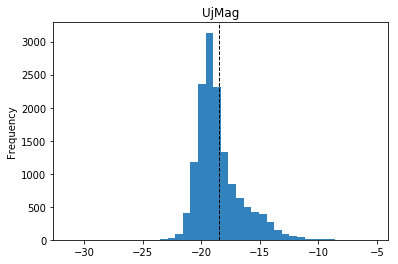

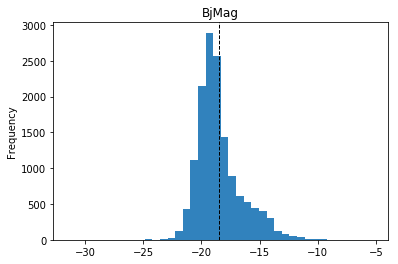

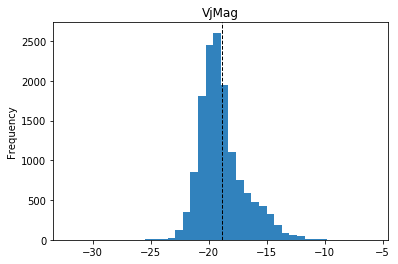

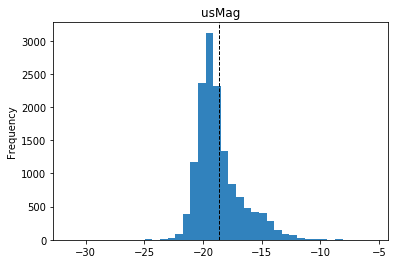

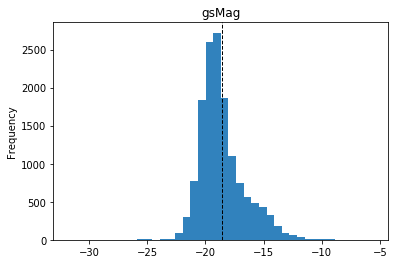

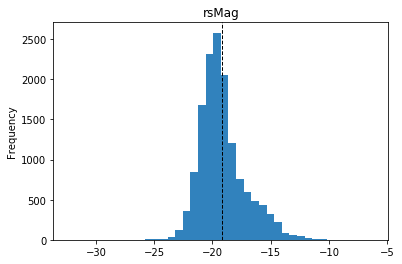

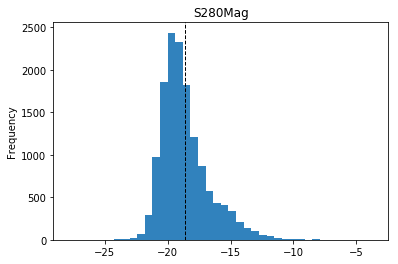

In [85]:
# Plot the distribution of magnitudes as histograms
for column in mags:
    mags[column].plot(kind='hist', bins=40, colormap='tab20c')
    plt.title(column)
    mean = np.mean(mags[column])
    plt.axvline(mean, color ='k',linestyle='dashed', linewidth=1)
    plt.show()


The photon fluxes are the observed brightnesses across different bands. The first 13 fluxes are measured in bands from 420nm to 915nm. The last five fluxes are from measurements in the traditional broad spectral bands, ultraviolet, blue, visible, red, and infrared. As the name broad band suggest, each of these bands covers a wider range of wavelengths than the previous bands. The units are photon flux densities, photons/m$^{2}$/s/sm. 

The vast majority of the photon fluxes are close to zero, therefore a log scale has been used on the y-axis to better show the shape of the distributions. 

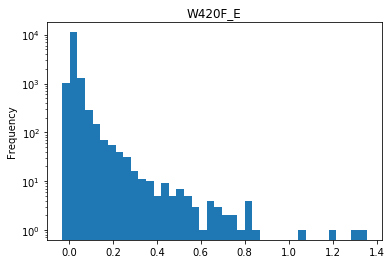

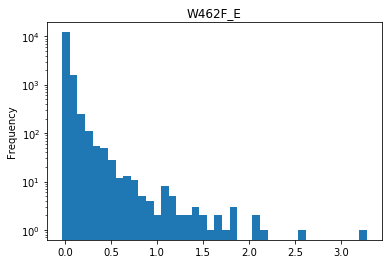

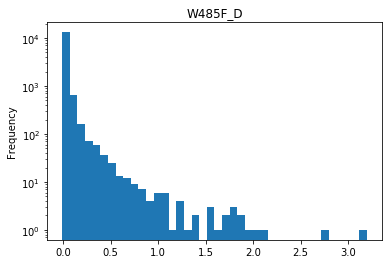

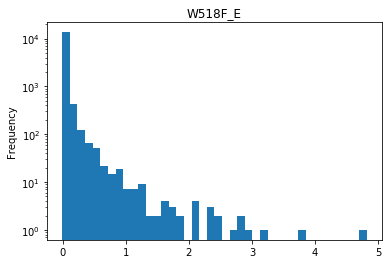

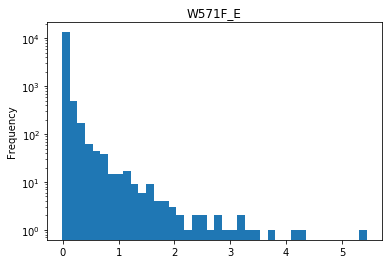

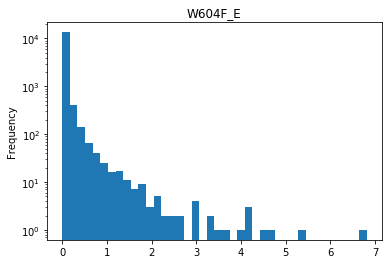

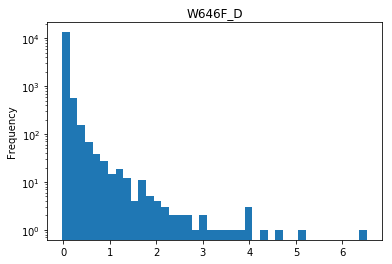

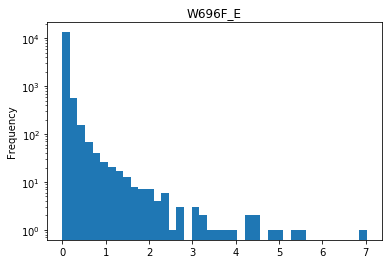

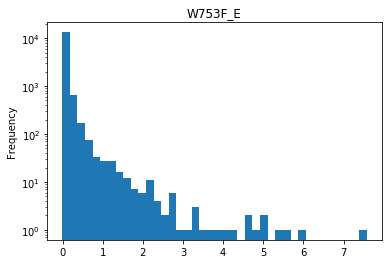

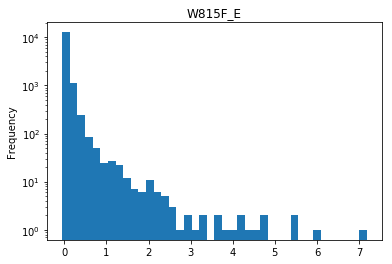

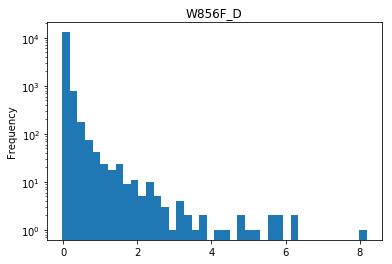

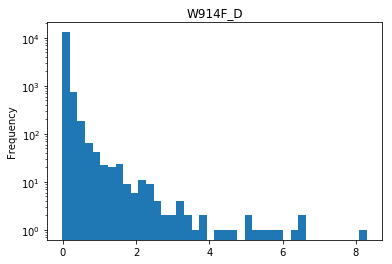

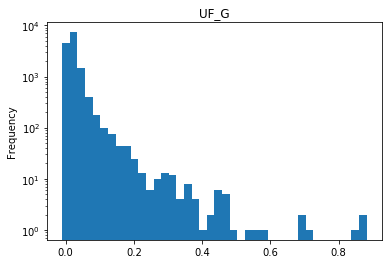

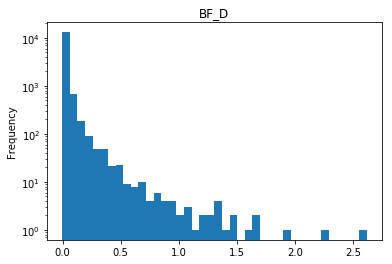

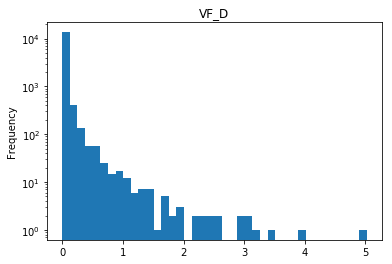

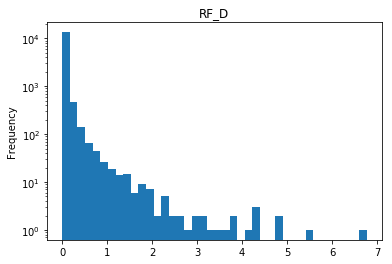

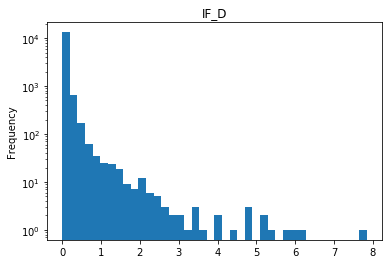

In [86]:
# Plot the distribution of photon fluxes as histograms
for column in flux:
    flux[column].plot(kind='hist', bins=40)
    plt.title(column)
    plt.yscale('log')
    plt.show()

The magnitudes and photon fluxes both have corresponding errors. These have been plotted as histograms, showing that overall the errors are very low. There are more outliers for the magnitude errors than for the photon flux errors. This is expected, as magnitude are a calculated value whereas photon fluxes are measured directly by the telescope. 

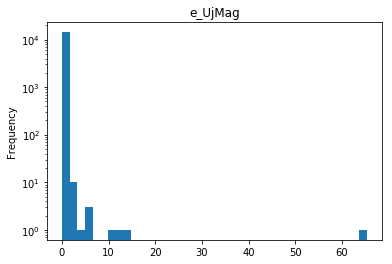

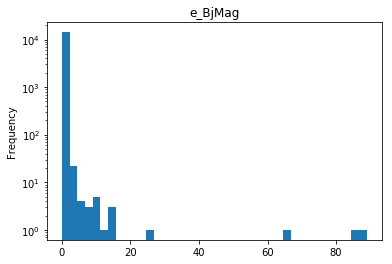

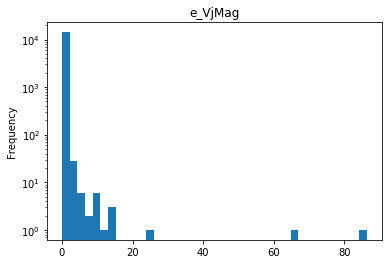

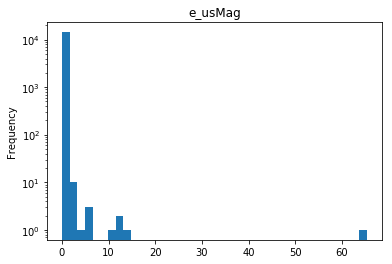

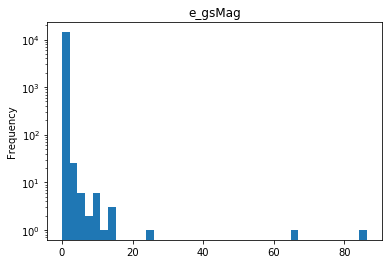

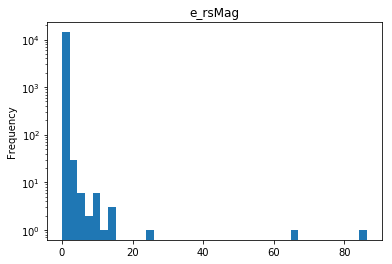

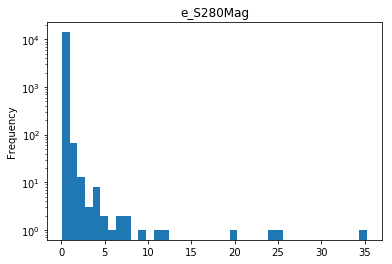

In [87]:
# Plot the distribution of magnitude errors as histograms
for column in magsErr:
    magsErr[column].plot(kind='hist', bins=40)
    plt.title(column)
    plt.yscale('log')
    plt.show()

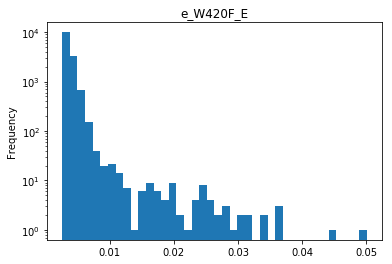

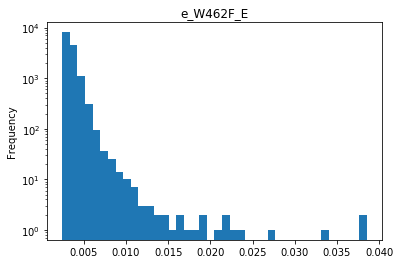

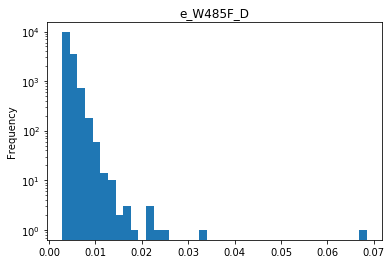

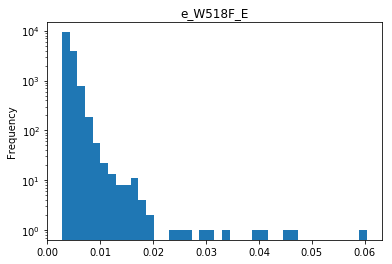

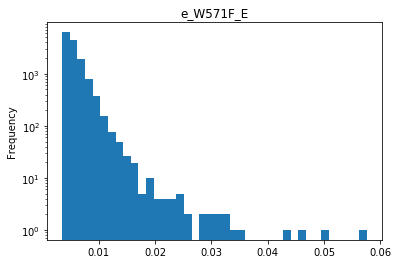

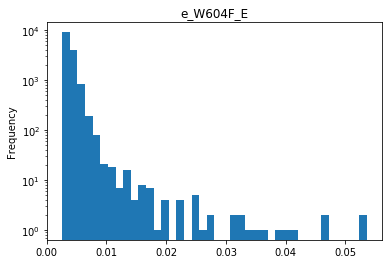

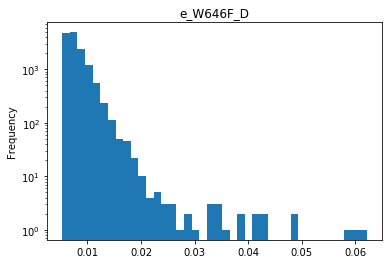

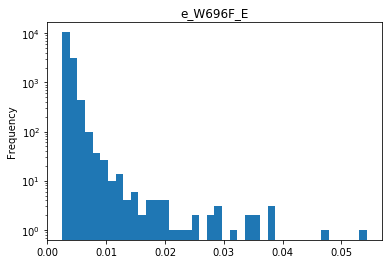

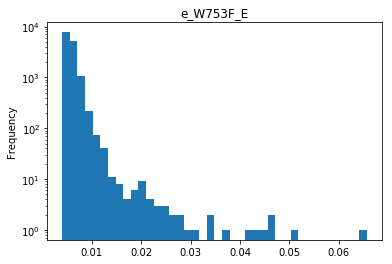

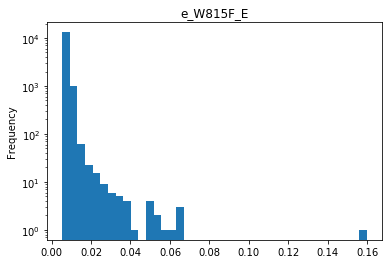

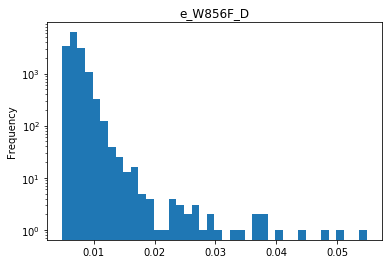

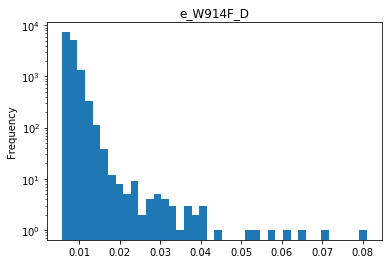

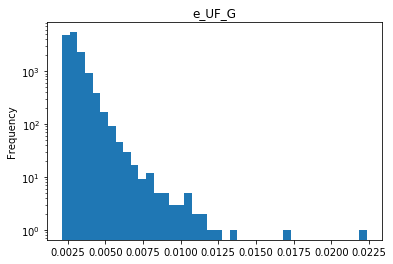

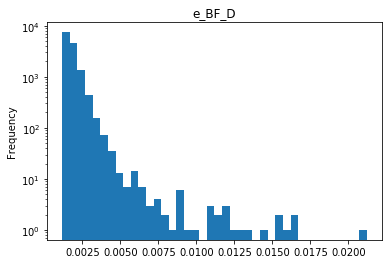

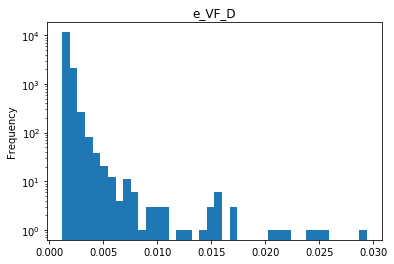

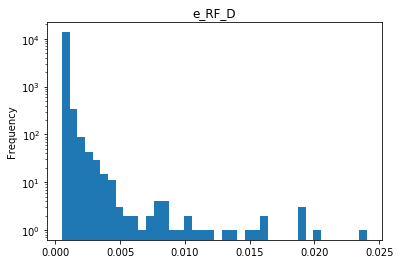

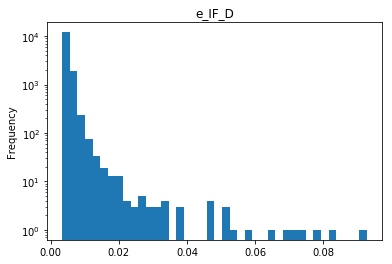

In [88]:
# Plot the distribution of photon flux errors as histograms
for column in fluxErr:
    fluxErr[column].plot(kind='hist', bins=40)
    plt.title(column)
    plt.yscale('log')
    plt.show()

The redshifts for the data set range from 0 to 1.6, corresponding to distances of approximately 0 to 12000 Mpc, or 0 to 39$\times$ 10$^{9}$ light years. The distribution of redshifts is not normal. This is expected because the distribution of galaxies across the Chandra Deep Field South's field of view is not expected to be normal. Galaxy clusters could cause spikes in redshifts around certain values. The tapering off of the distribution towards the high end of the range of redshifts is expected, as higher redshift objects would be more likely to be obscured or not positively identified as galaxies.

Chi$^{2}$ is plotted with a logarithmic y-axis, showering that there are very few values where the photometric redshift did not fit the model well.

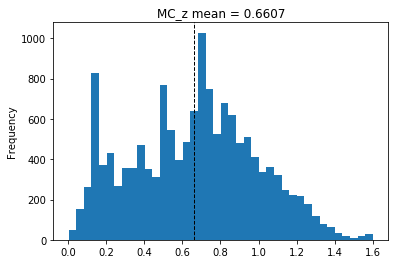

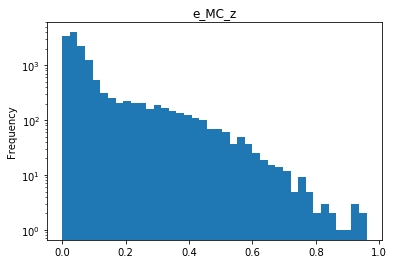

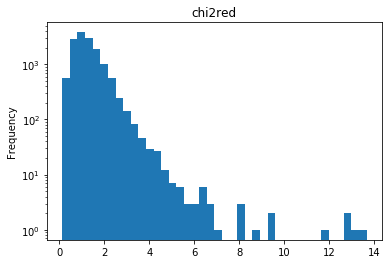

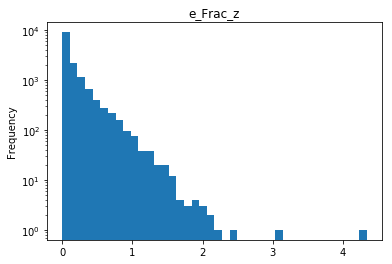

In [89]:
# Plot the distribution of redshifts as histograms
redshift['MC_z'].plot(kind='hist', bins=40)
mean = np.mean(redshift['MC_z'])
plt.title('MC_z mean = {:.4f}'.format(mean))
plt.axvline(mean, color ='k',linestyle='dashed', linewidth=1)
plt.show()

for column in redshift:
    if column != 'MC_z':
        redshift[column].plot(kind='hist', bins=40)
        plt.yscale('log')
        plt.title(column)
        plt.show()

Plotting the redshifts vs the errors, chi$^{2}$, and fractional errors show that there is very little correlation between the redshifts and the chi$^{2}$ values or the redshifts and the fractional errors. This is good, given that if there was a positive correlation then the higher redshift values would be less reliable in general. There is a small increase of fractional errors towards values of z=0, which is expected because the denominator would be approaching zero while the numerator stayed roughly constant.

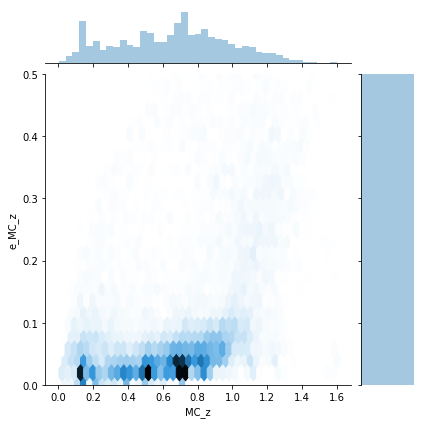

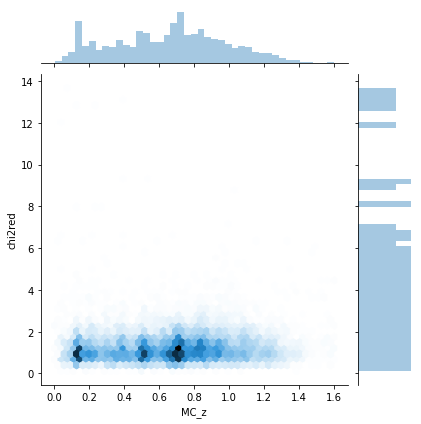

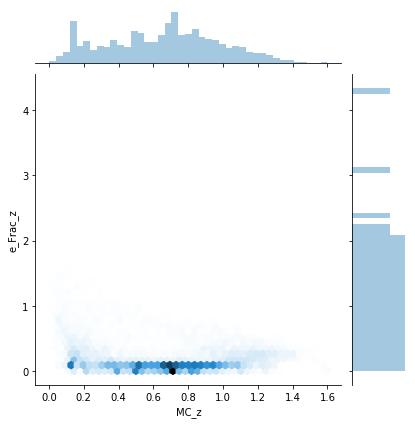

In [90]:
# see the correlation between the erros, chi2, and frac errors
# on the redshifts
sns.jointplot(x='MC_z',y='e_MC_z',data=redshift, kind='hex')
plt.ylim(0,0.5)
plt.xlim(0,1.4)
plt.show()

sns.jointplot(x='MC_z',y='chi2red',data=redshift, kind='hex')
plt.xlim(0,1.4)
plt.show()

sns.jointplot(x='MC_z',y='e_Frac_z',data=redshift, kind='hex')
plt.xlim(0,1.4)
plt.show()

The fractional errors for the magnitudes and fluxes show that almost all of the fractional errors are close to zero with only a few outliers for each magnitude and flux. For the magnitudes, the outliers occur thoughout the range of the distribution of magnitudes, centered around where the distribution is most dense. For the fluxes, the outliers of fractional errors all occur close to the flux equaling zero. This occurs for the same reason that there was an upward trend for fractional errors on the redshifts - when the denomenator is close to zero the fractional error is more likely to be large.   

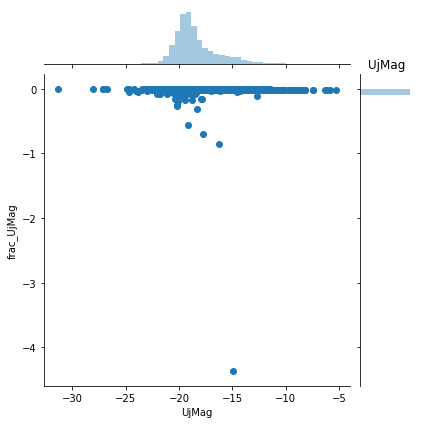

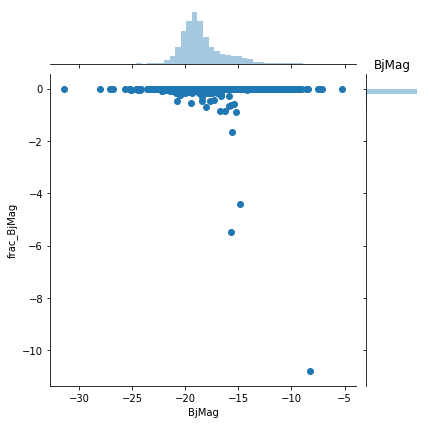

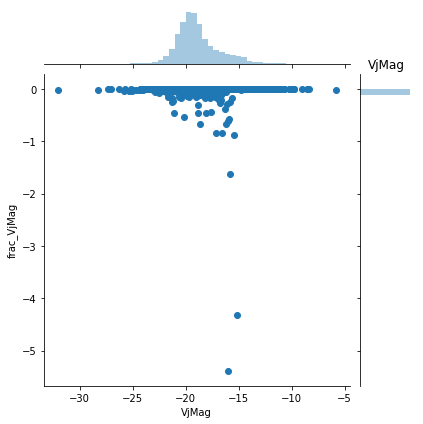

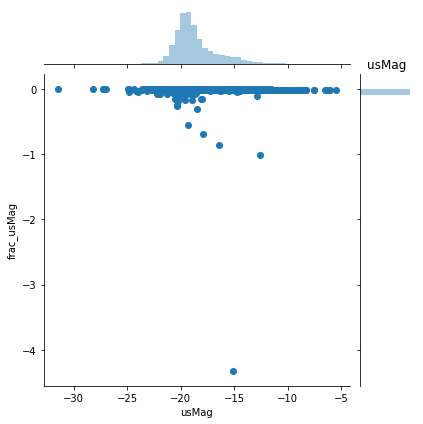

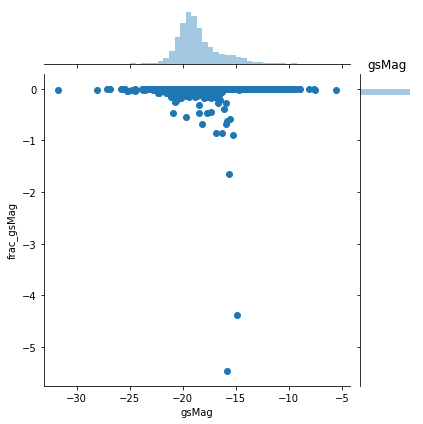

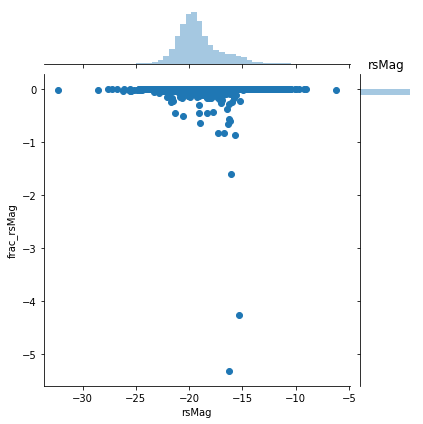

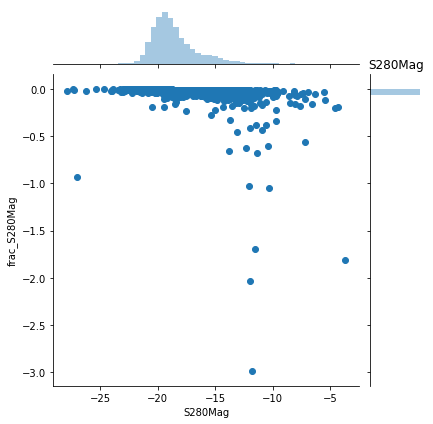

In [91]:
# look at fractional errors for magnitudes
fracMagErr = magsErr/mags.values
fracMagErr.columns = ['frac_UjMag', 'frac_BjMag', 'frac_VjMag',
                      'frac_usMag', 'frac_gsMag', 'frac_rsMag',
                      'frac_S280Mag']
for column in mags:
    sns.jointplot(x=mags[column], y=fracMagErr['frac_'+column])
    plt.title(column)
    plt.show()
    

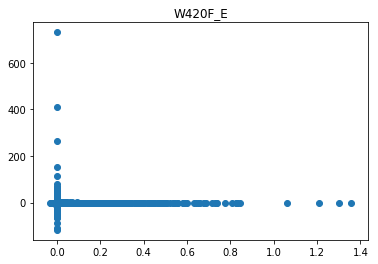

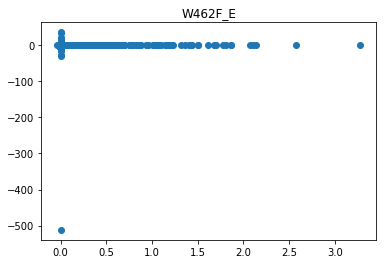

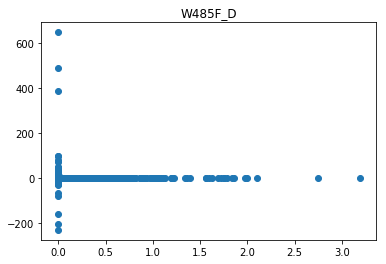

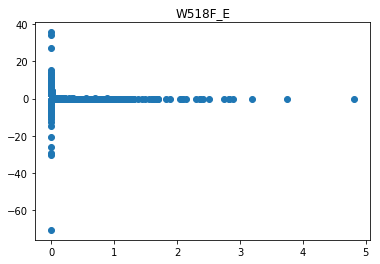

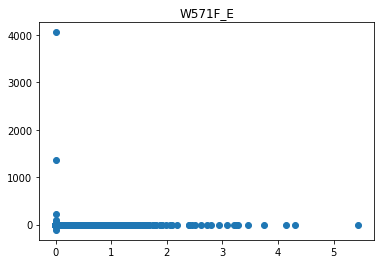

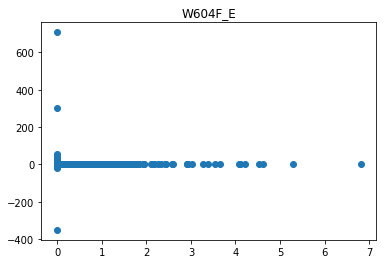

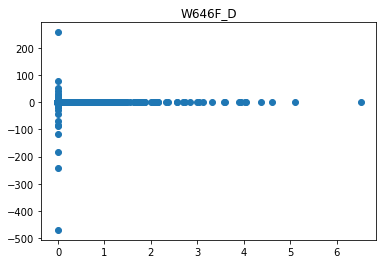

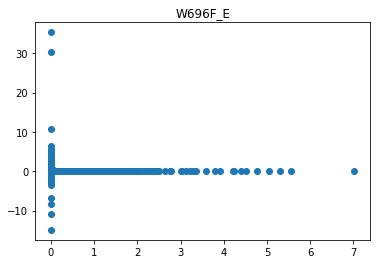

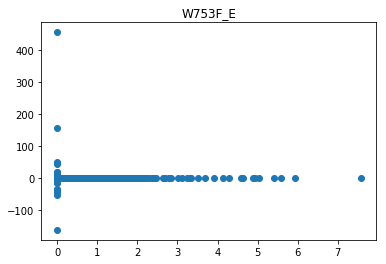

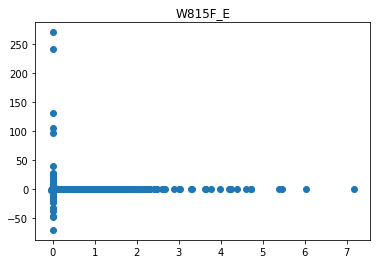

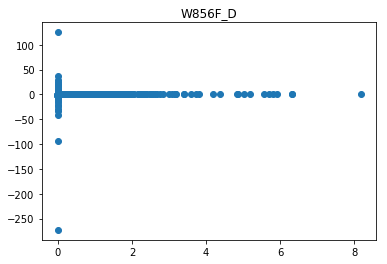

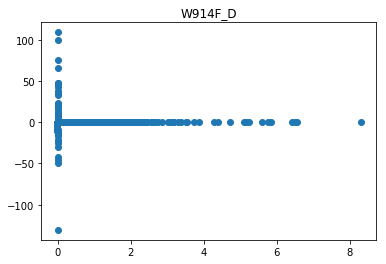

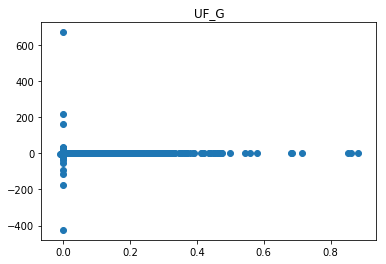

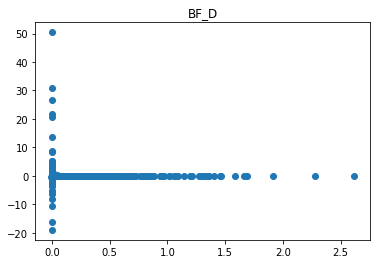

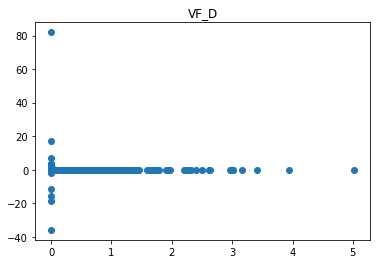

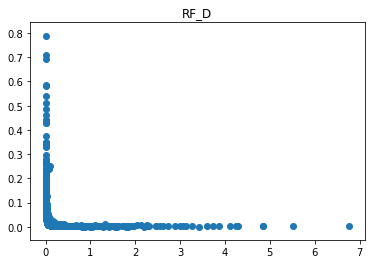

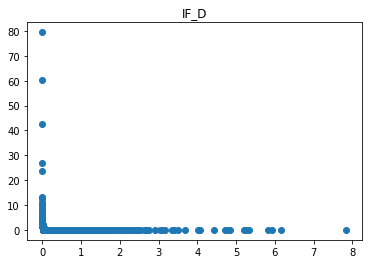

In [92]:
# look at fractional errors for fluxes
fracFluxErr = fluxErr/flux.values
fracFluxErr.columns = flux.columns

for column in flux:
    plt.scatter(flux[column], fracFluxErr[column])
    plt.title(column)
    plt.show()
    
#make these plots look nicer
#decide what to do with outliers

The correlations between the magnitudes and redshifts could be vital to building a model to predict the reshifts. All seven of the magnitudes are inversely correlated to the redshifts. Additionally, each graph follows an inverted 'S' curve, a distinct shape showing that the least luminous galaxies could only be seen at low redshifts.

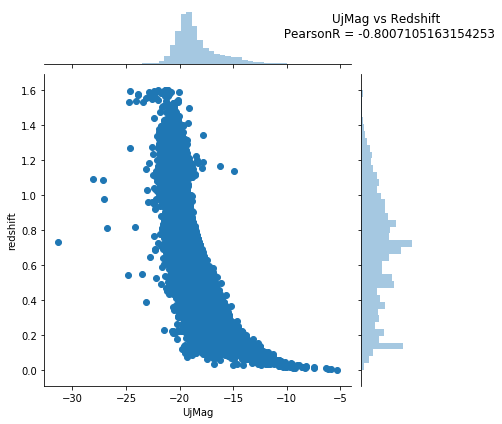

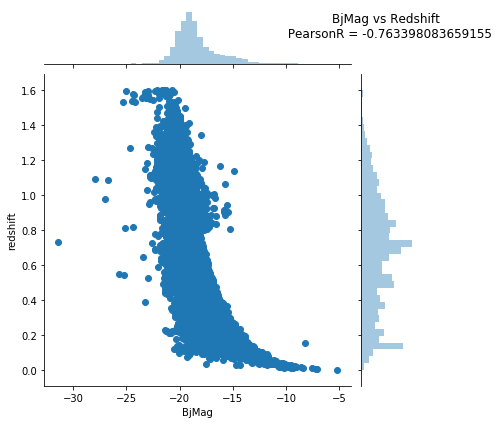

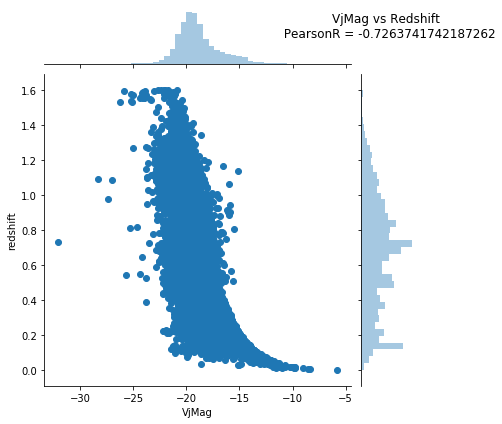

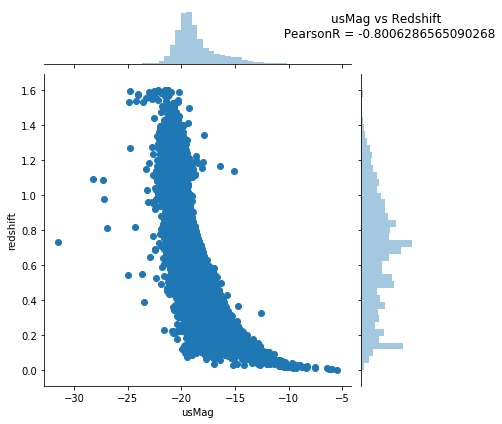

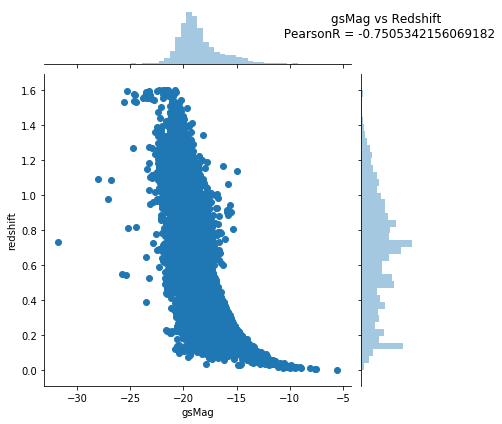

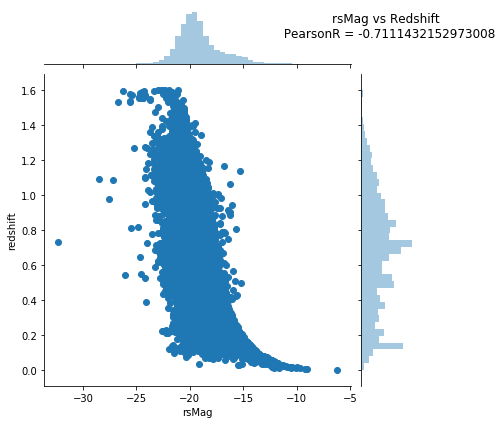

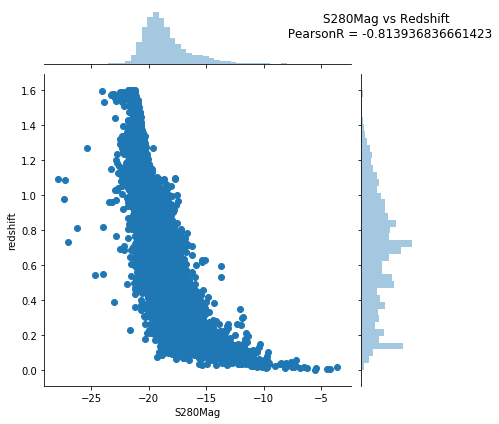

In [93]:
# look at correlations between redshifts
magRedPairs = []

for column in mags:
    (r, p) = pearsonr(mags[column], redshift['MC_z'])
    if ((r>0.5) or (r<-0.5)) and (p!=1) and (r!=1):
        magRedPairs.append((column,r))
            
#print(magRedPairs)
#plot all of these pairings
mags['redshift'] = redshift['MC_z']
for i in range(7):
    sns.jointplot(x=mags[magRedPairs[i][0]], y='redshift', data=mags)
    plt.title(magRedPairs[i][0] + ' vs Redshift \n PearsonR = ' + str(magRedPairs[i][1]),
             y = 1.1)
    plt.show()


There is no correlation between the redshifts and the errors in the magnitudes. Therefore the magnitude errors may not be useful in the model.

Text(0.5,1,'Correlations between magnitude error and redshift')

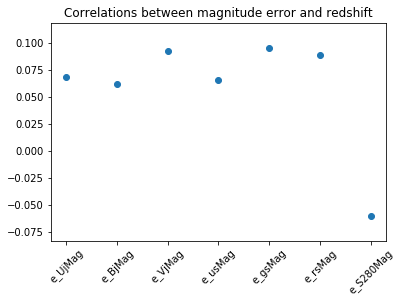

In [94]:
# look at correlations between redshifts and mag errors
magErrRedPairs = []

for column in magsErr:
    (r, p) = pearsonr(magsErr[column], redshift['MC_z'])
    magErrRedPairs.append((column,r))
            

plt.scatter([x[0] for x in magErrRedPairs], [x[1] for x in magErrRedPairs])
plt.xticks(rotation=45)
plt.title('Correlations between magnitude error and redshift')

There is not a linear correlation between the fluxes and the redshifts as there was for the magnitudes and redshifts. For each band, the photon flux only ranged above 1 photons/m$^{2}$/s/sm for redshifts below around 0.2. As expected, the Chandra Deep Field South survey was able to find more photons associated with closer galaxies than farther galaxies

Text(0.5,1,'Correlations between photon flux and redshift')

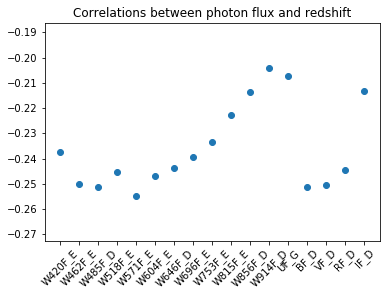

In [95]:
# look at correlations between redshifts and fluxes
fluxRedPairs = []

for column in flux:
    (r, p) = pearsonr(flux[column], redshift['MC_z'])
    fluxRedPairs.append((column,r))
            
plt.scatter([x[0] for x in fluxRedPairs], [x[1] for x in fluxRedPairs])
plt.xticks(rotation=45)
plt.title('Correlations between photon flux and redshift')


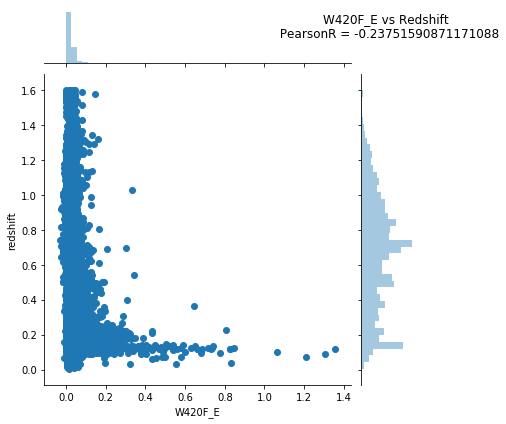

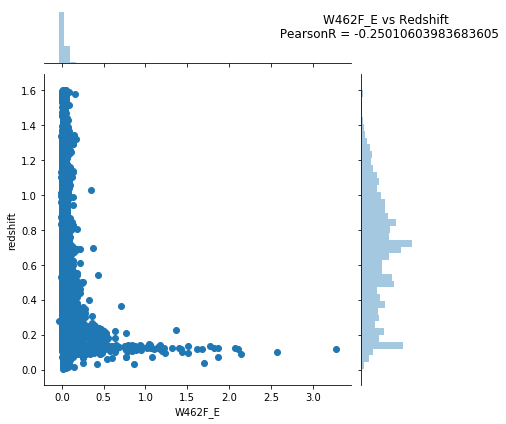

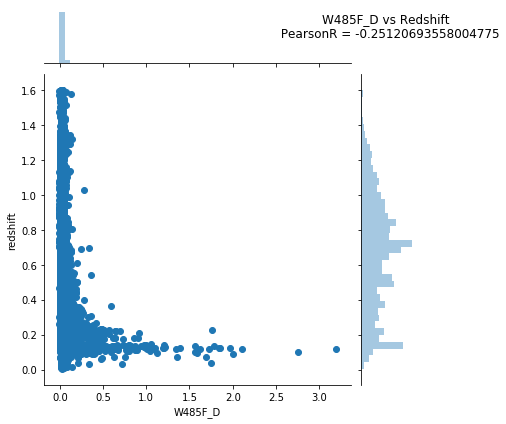

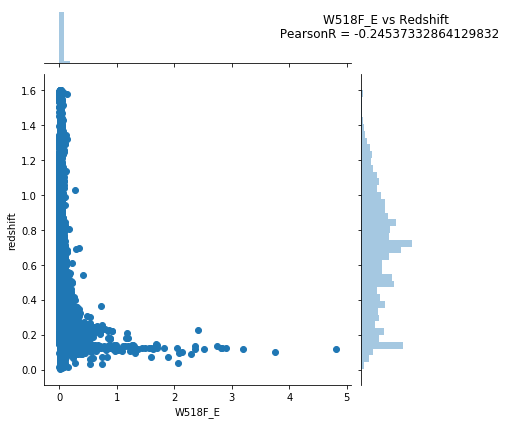

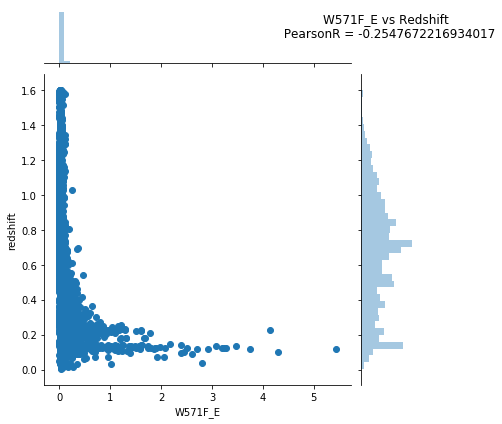

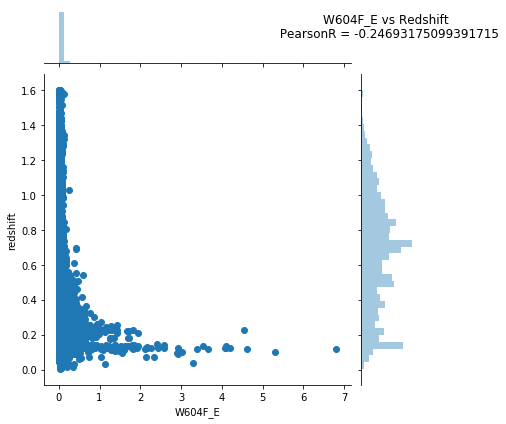

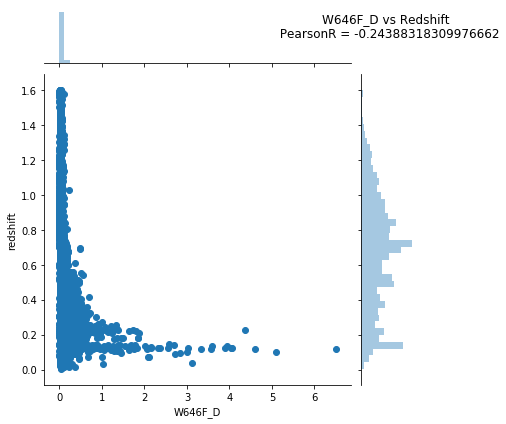

In [96]:
#plot all of these pairings
flux['redshift'] = redshift['MC_z']
for i in range(7):
    sns.jointplot(x=flux[fluxRedPairs[i][0]], y='redshift', data=flux)
    plt.title(fluxRedPairs[i][0] + ' vs Redshift \n PearsonR = ' + str(fluxRedPairs[i][1]),
             y=1.1)
    plt.show()

As with the magnitude errors, there is not a meaningful correlation between the flux errors and the redshifts.

Text(0.5,1,'Correlations between magnitude error and redshift')

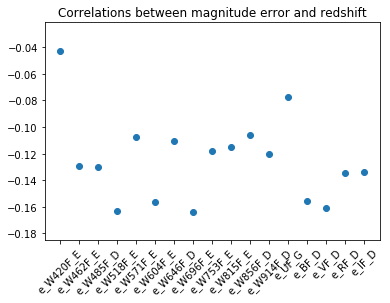

In [97]:
# look at correlations between reshifts and flux errors
fluxErrRedPairs = []

for column in fluxErr:
    (r, p) = pearsonr(fluxErr[column], redshift['MC_z'])
    fluxErrRedPairs.append((column,r))
            
plt.scatter([x[0] for x in fluxErrRedPairs], [x[1] for x in fluxErrRedPairs])
plt.xticks(rotation=45)
plt.title('Correlations between magnitude error and redshift')

The rates of extinction fpr different wavelengths of light across space leads to the assumption that the subtractions of magnitudes could display a meaningful pattern. When plotted against the redshifts, each subtraction shows a band where the differences in the magnitudes is larger. For example, the subtraction of UjMag-BjMag shows a band from approximately redshift 0.8 to 1.2. Not all subtractions have the band at the same range of redshifts, suggesting that this subtraction method could be utilized in the model.  

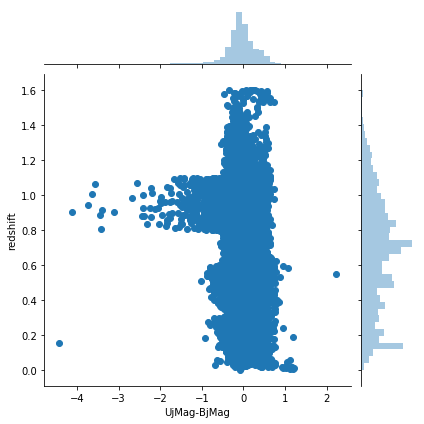

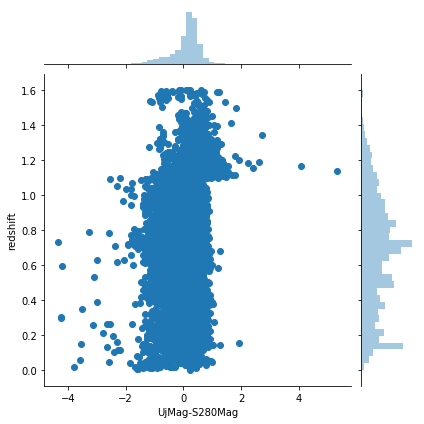

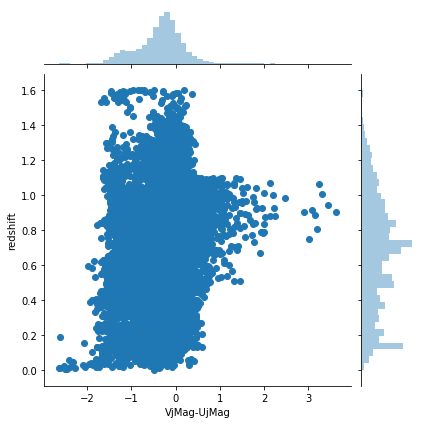

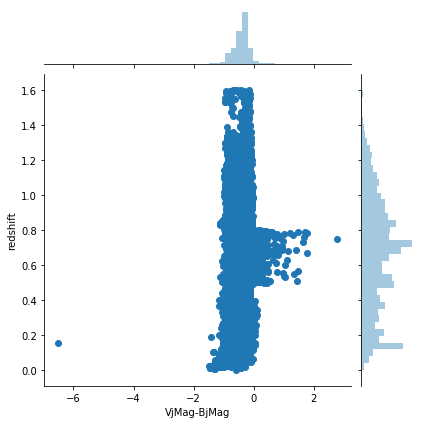

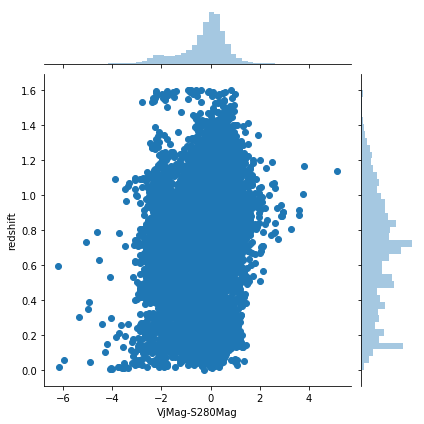

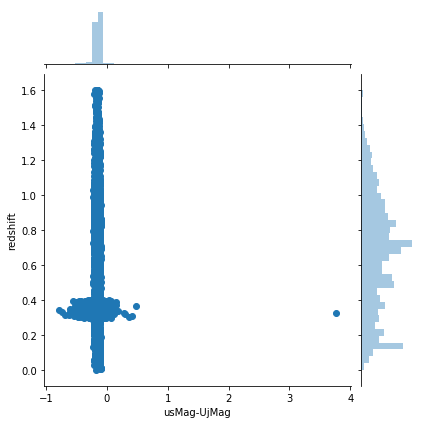

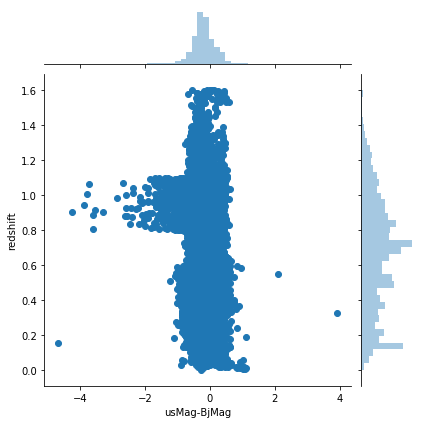

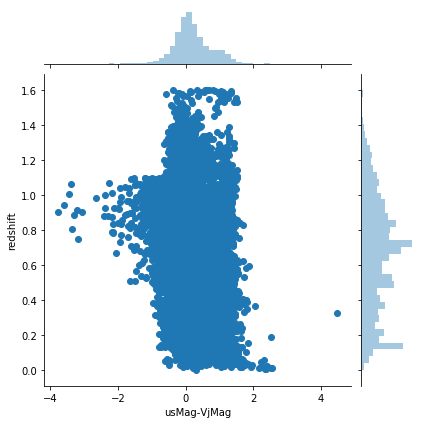

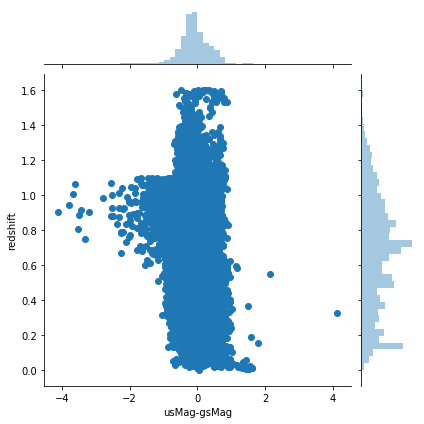

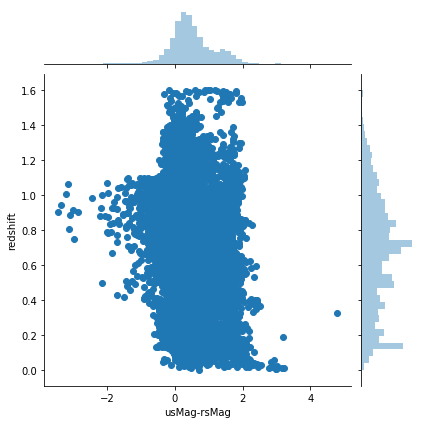

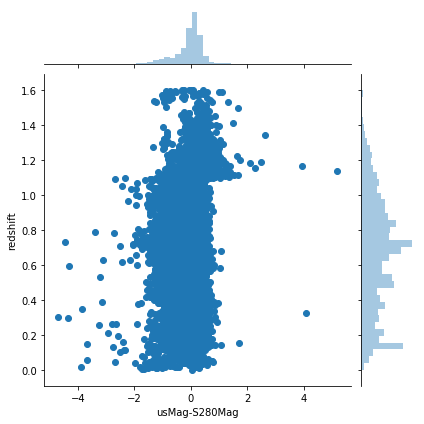

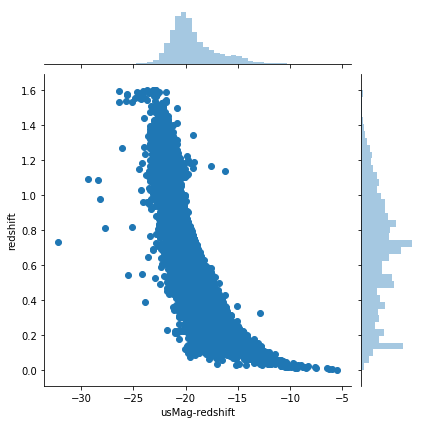

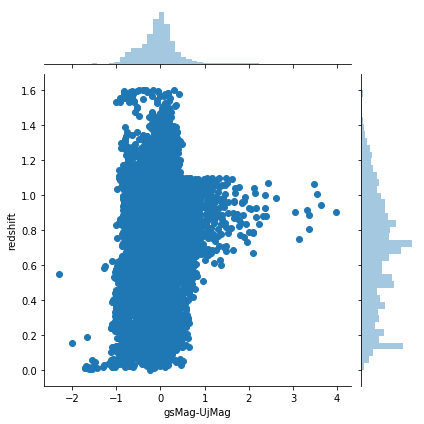

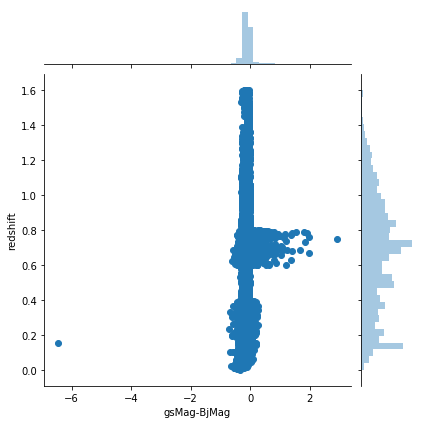

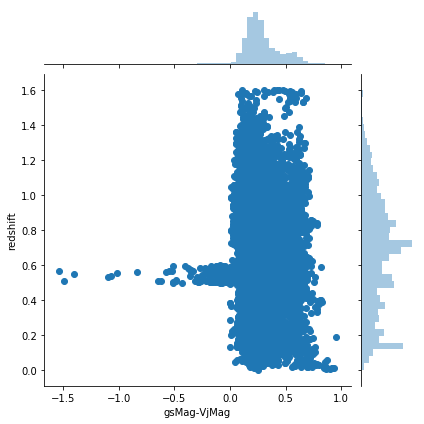

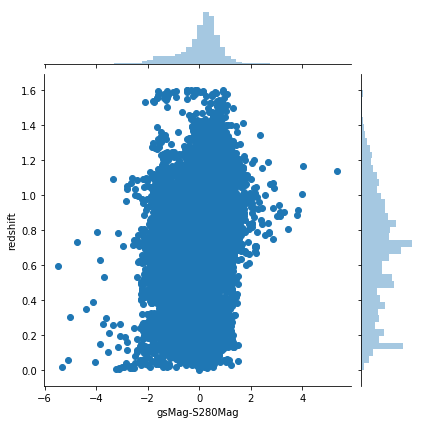

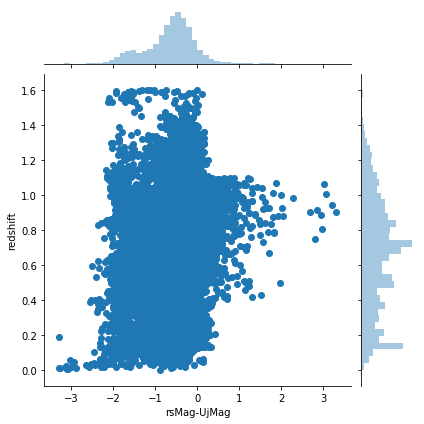

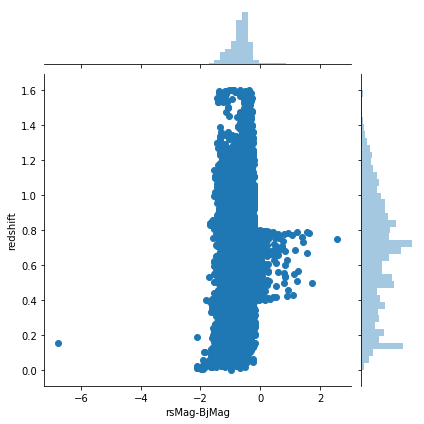

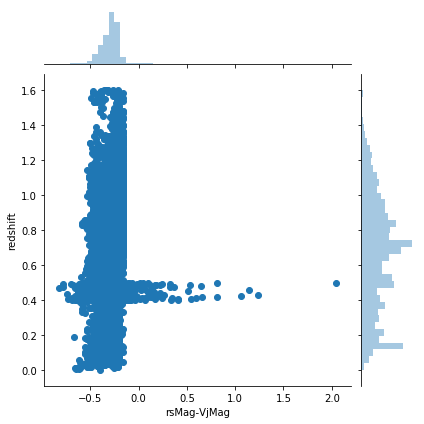

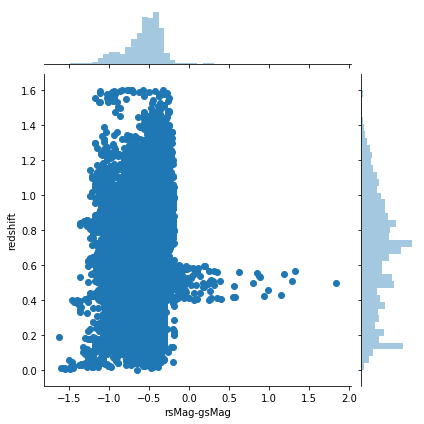

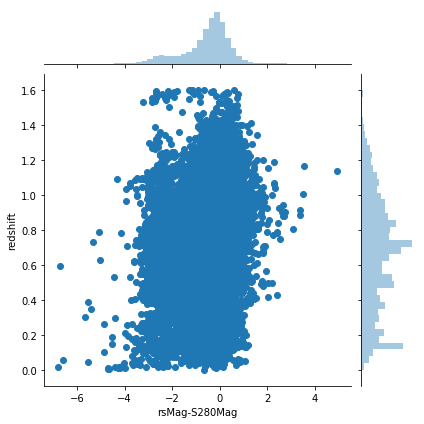

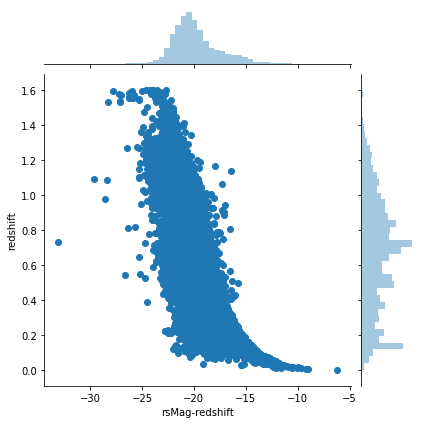

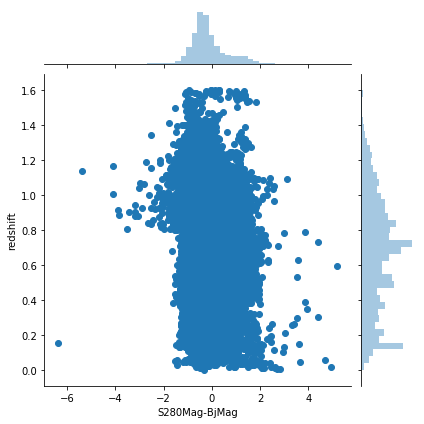

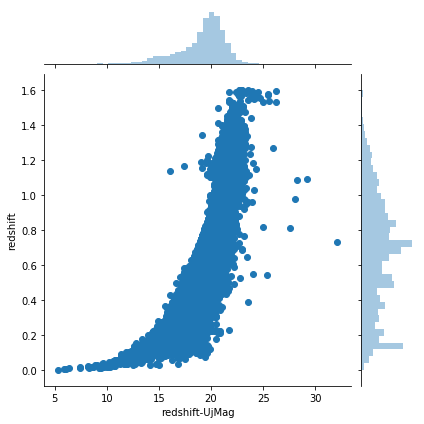

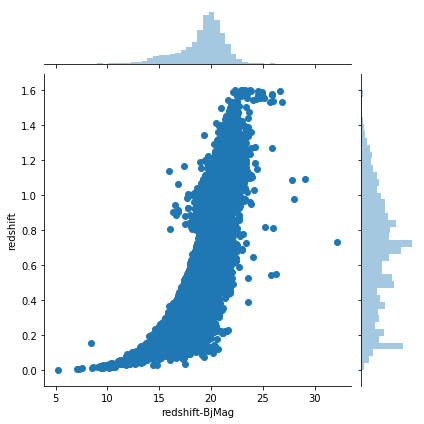

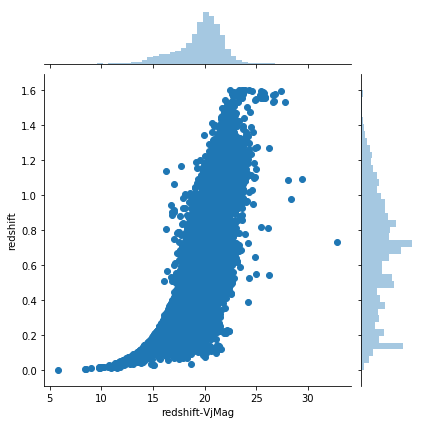

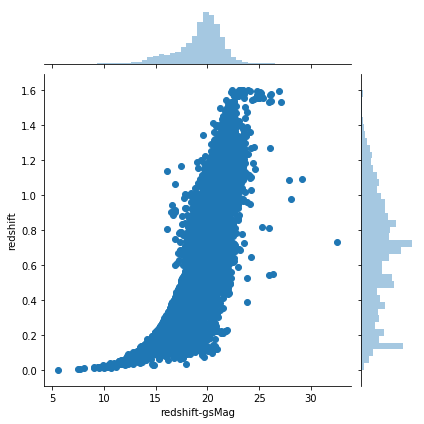

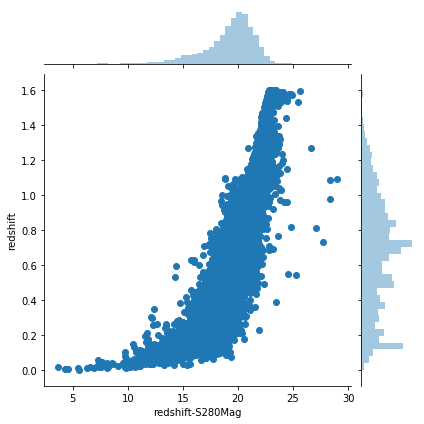

In [98]:
# look at the differences between the magnitudes vs redshifts
magDiffs = pd.DataFrame()
magDiffs['redshift'] = redshift['MC_z']
for column in mags:
    for column2 in mags:
        if (column > column2) and (column!='redshift') and (column2!='redshift'):
            magDiffs[column + '-' + column2] = mags[column] - mags[column2]
            
for column in magDiffs:
    if column != 'redshift':
        sns.jointplot(x=column,y='redshift',data=magDiffs)    
        plt.show()

Unfortunately, the flux subtractions do not show such an interesting behavior.

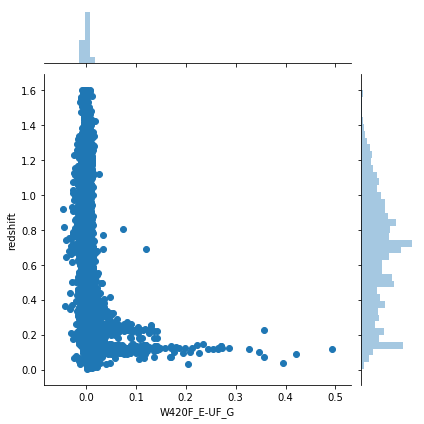

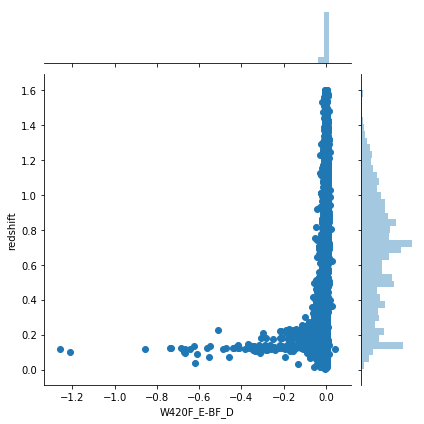

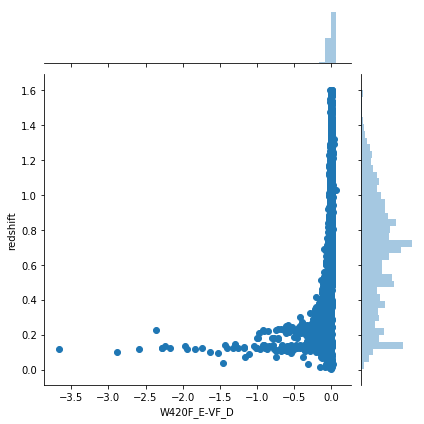

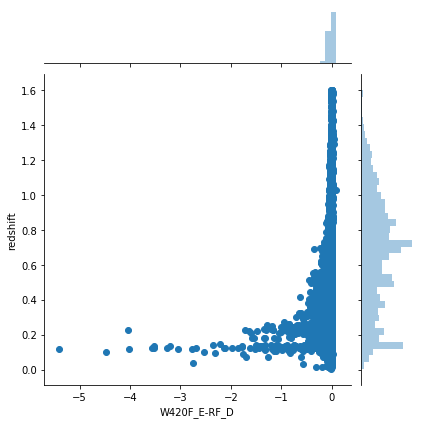

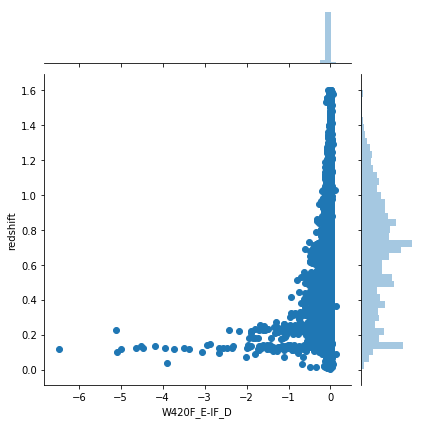

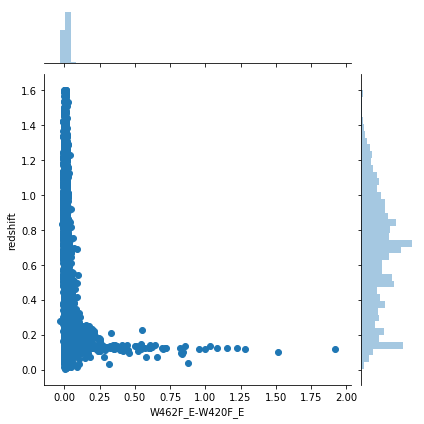

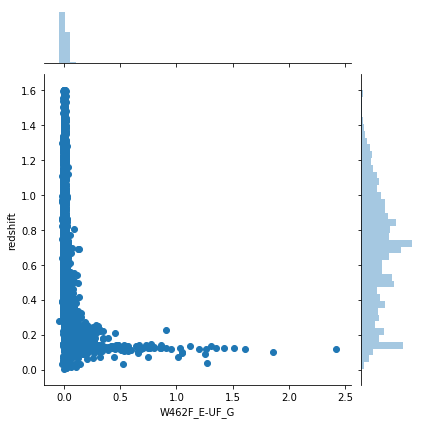

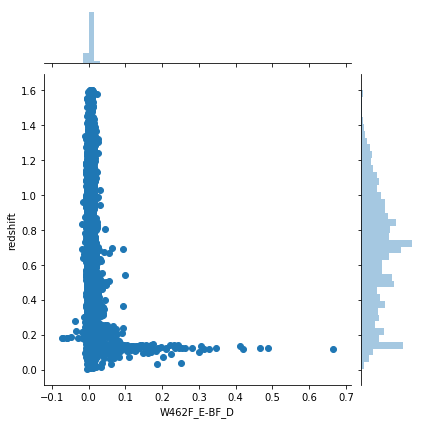

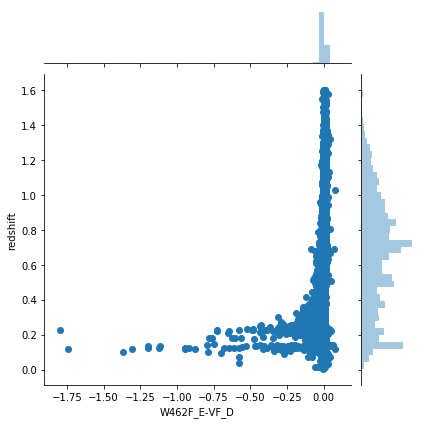

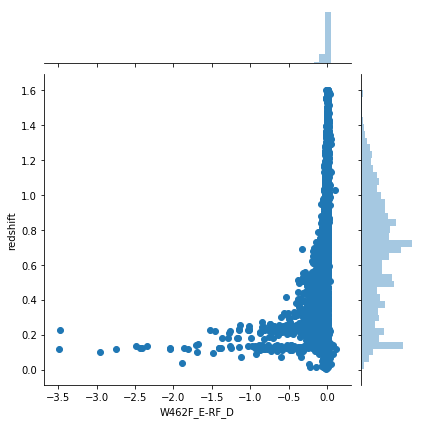

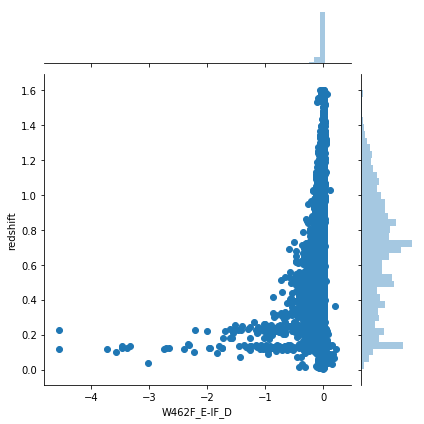

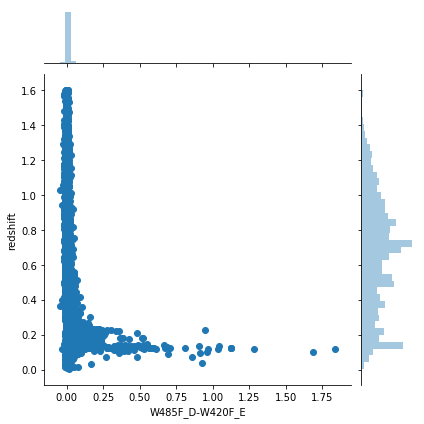

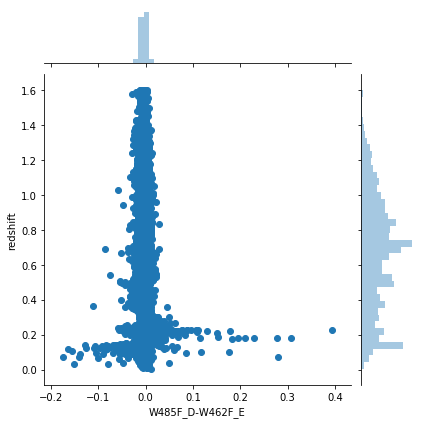

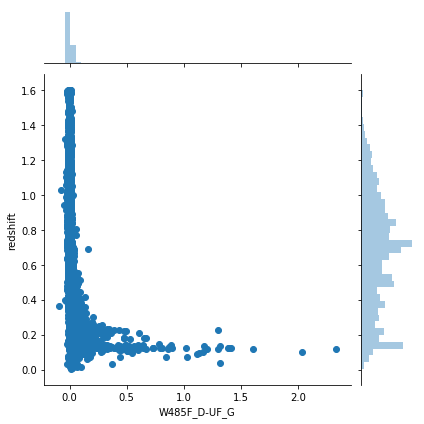

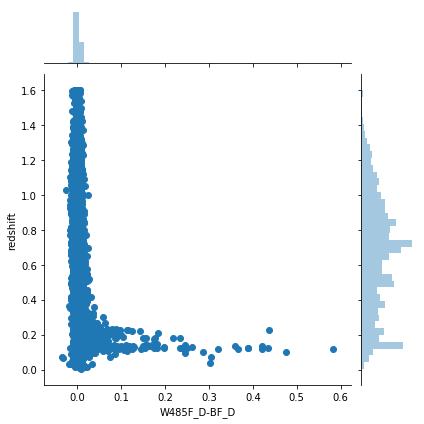

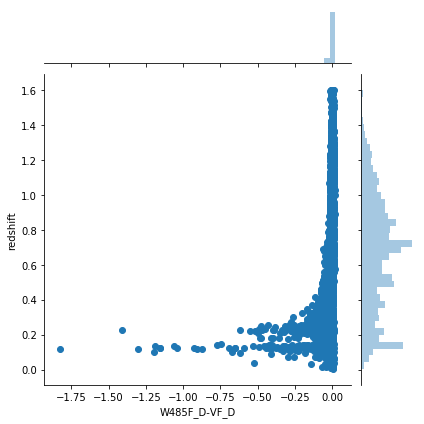

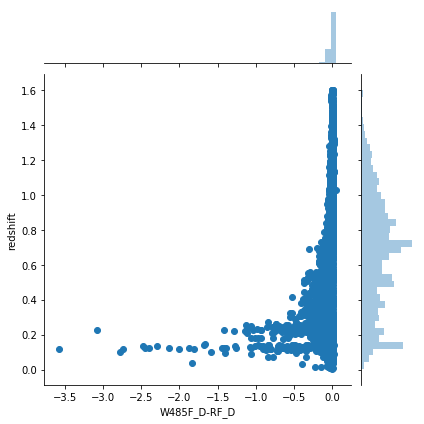

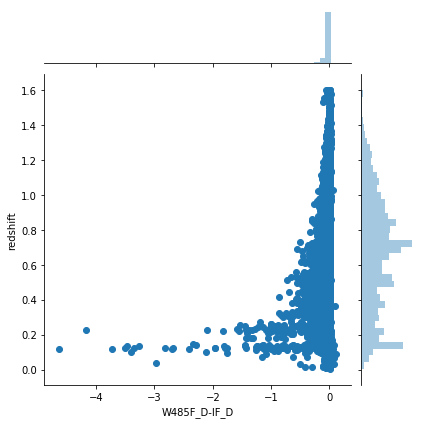

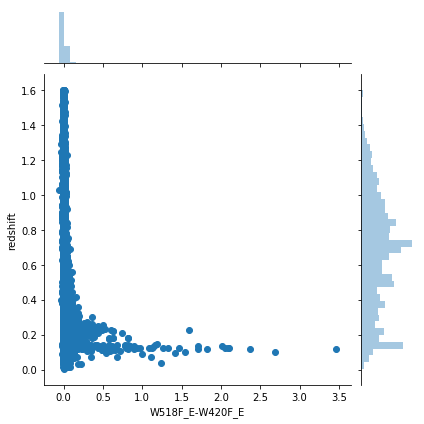

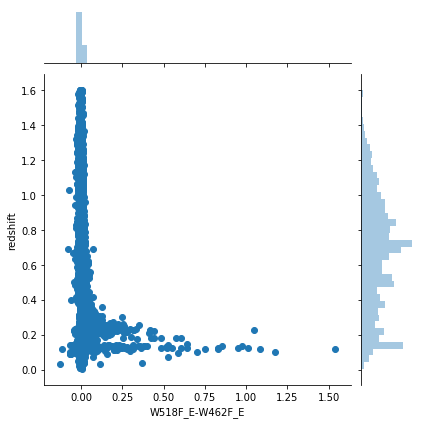

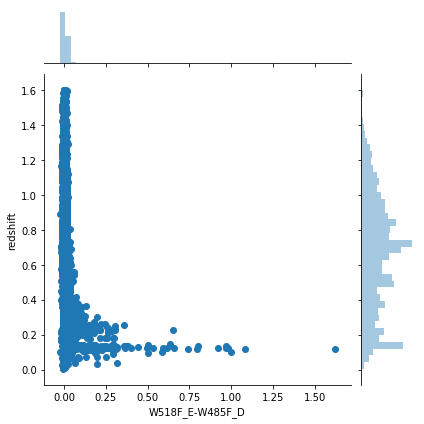

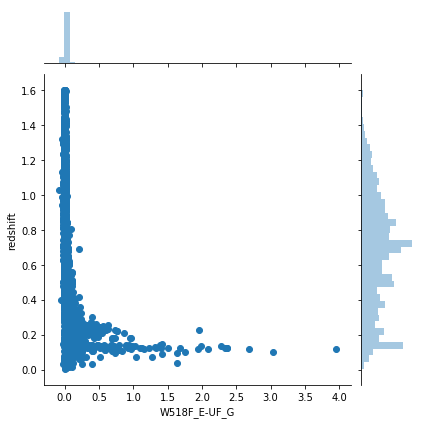

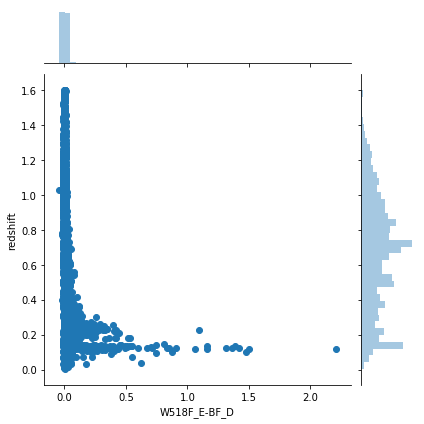

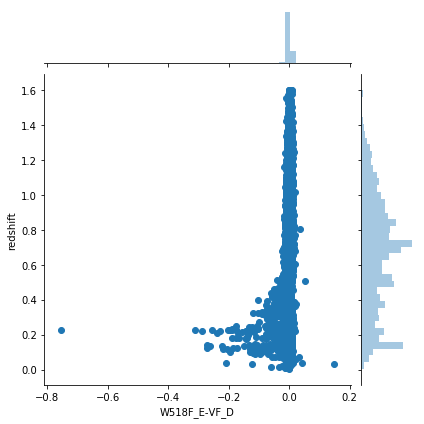

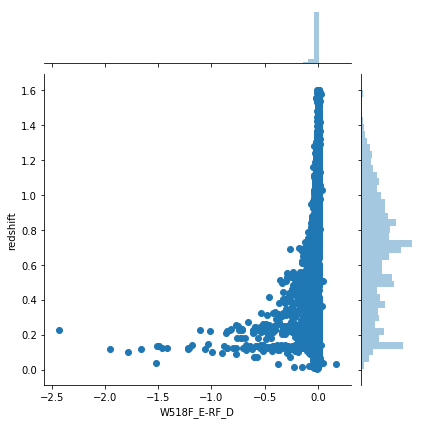

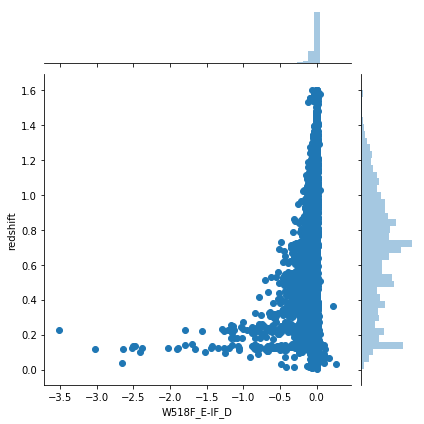

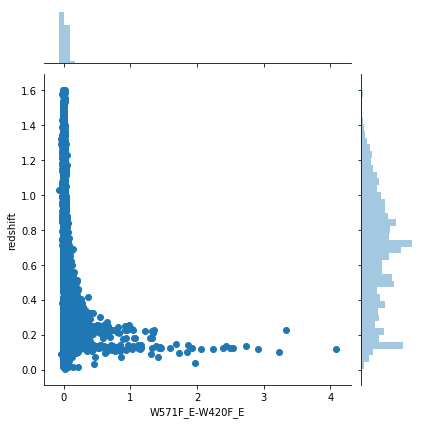

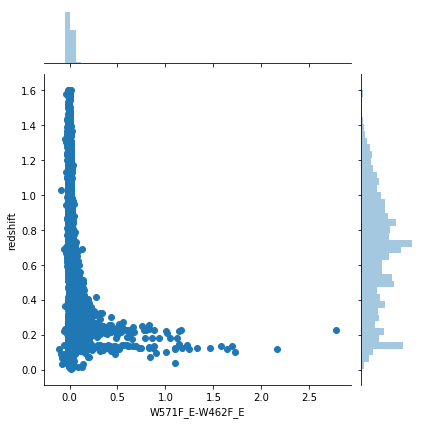

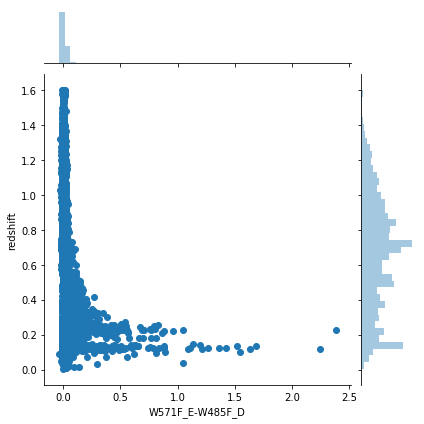

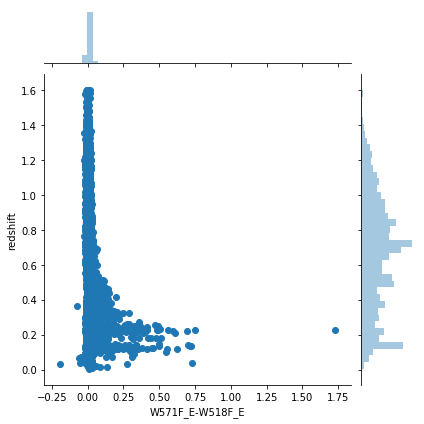

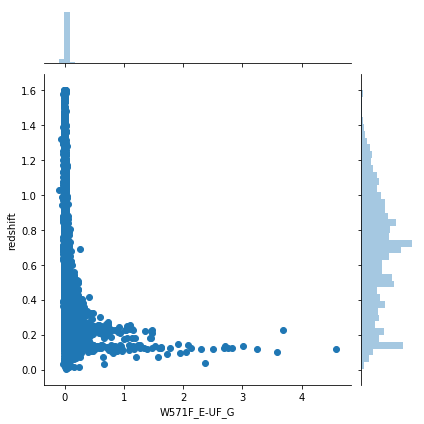

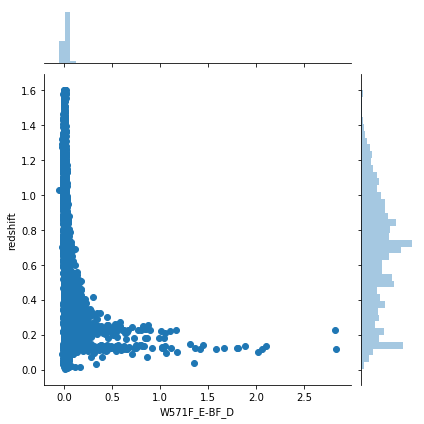

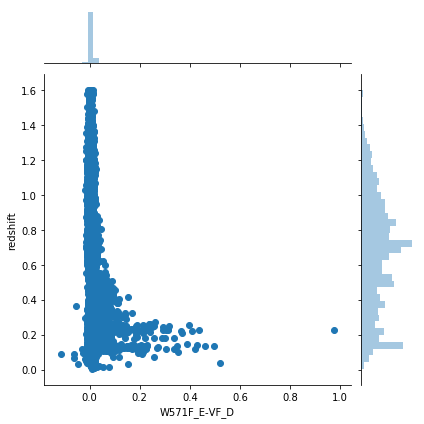

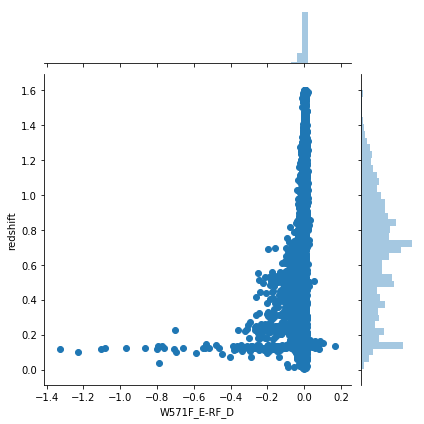

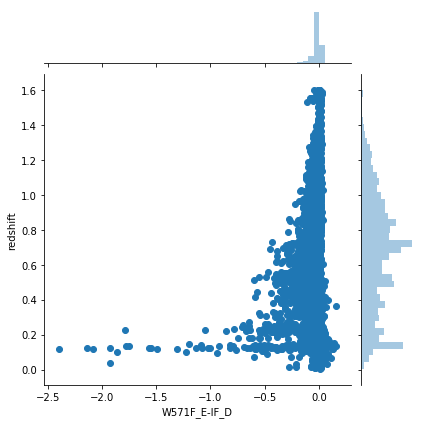

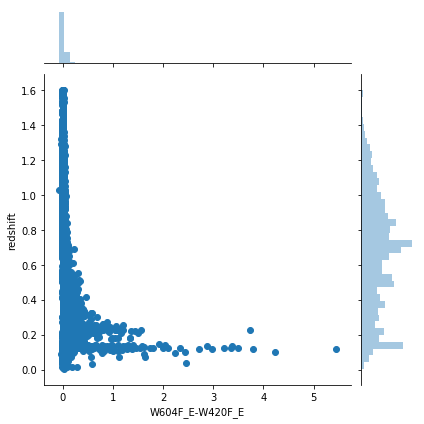

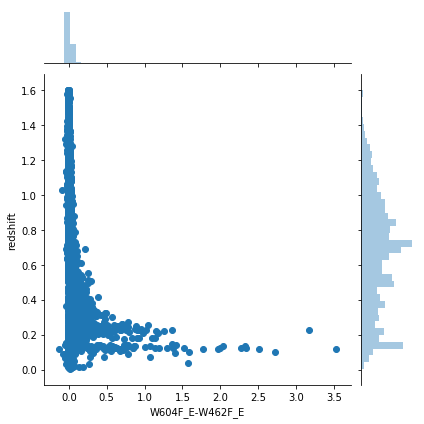

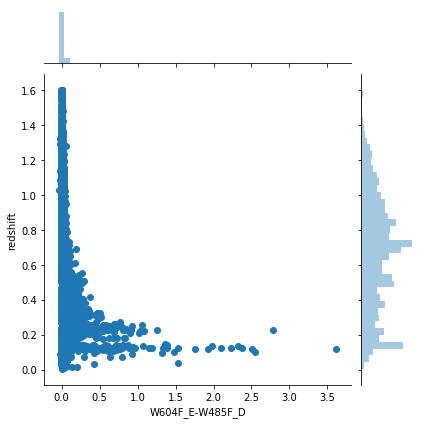

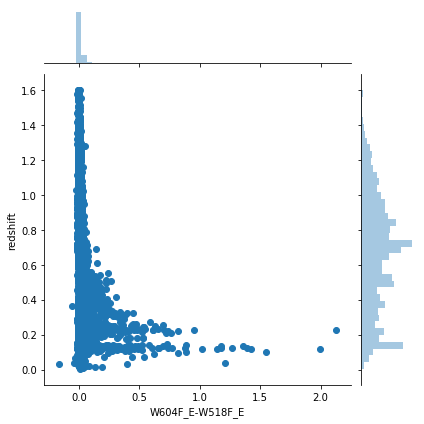

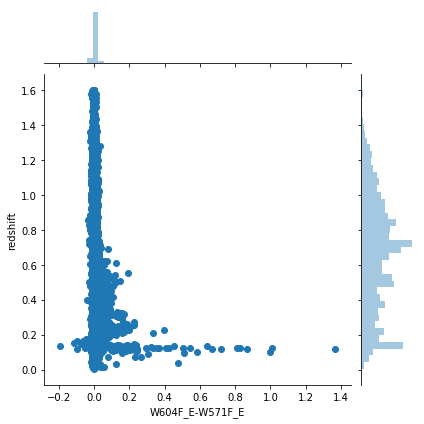

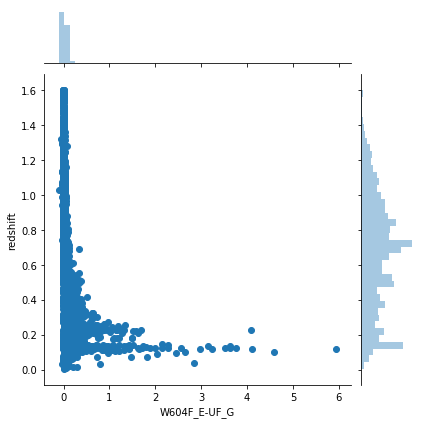

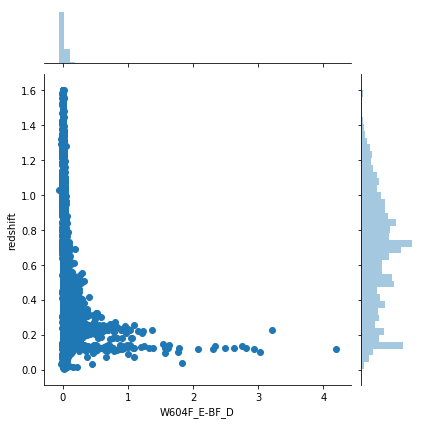

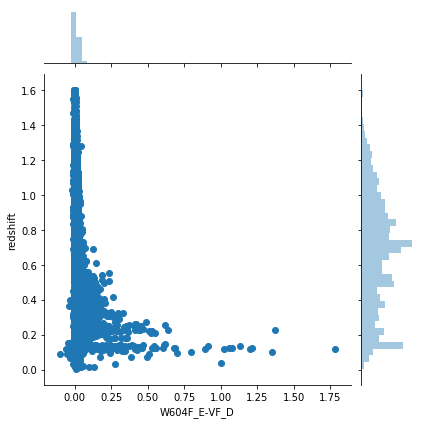

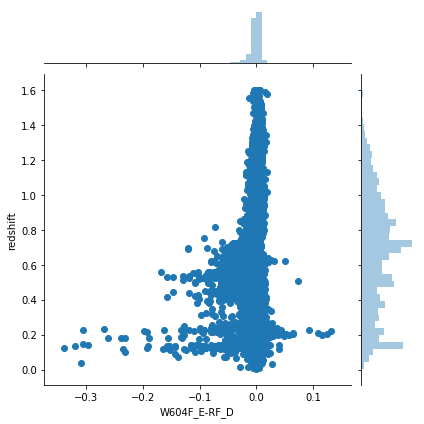

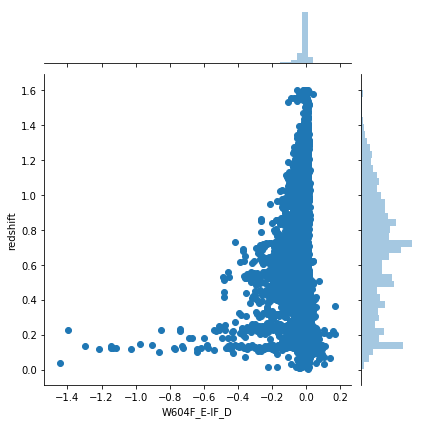

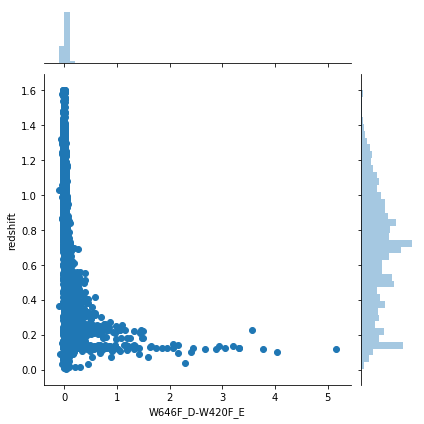

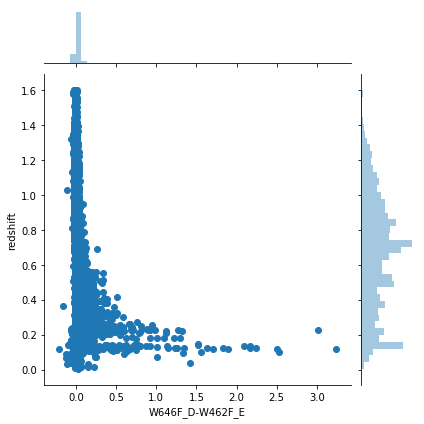

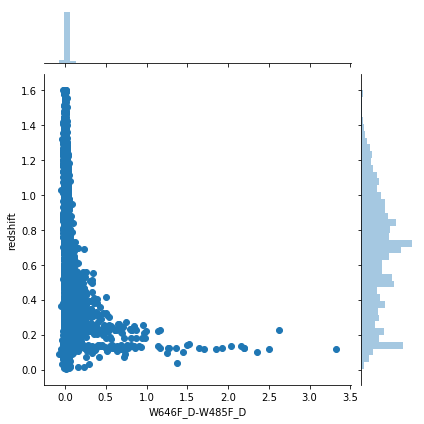

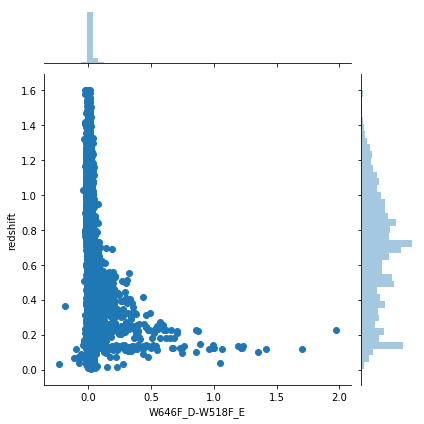

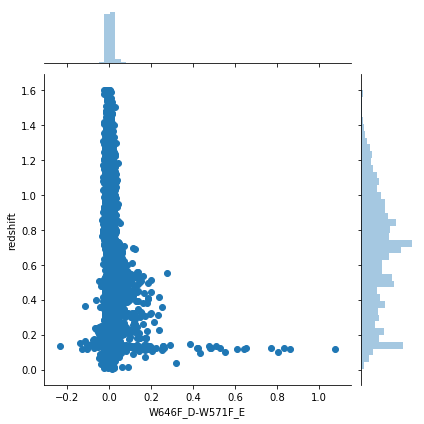

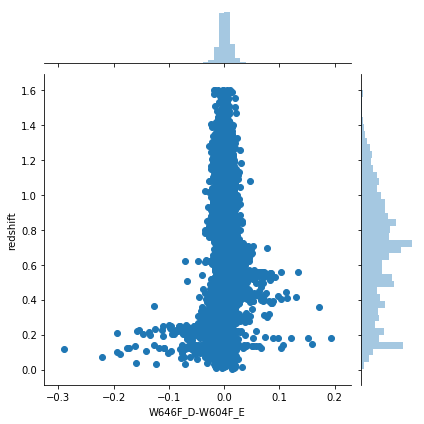

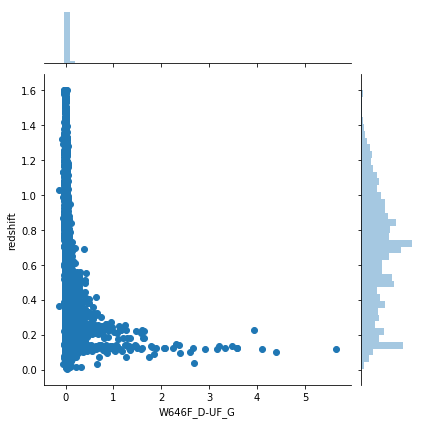

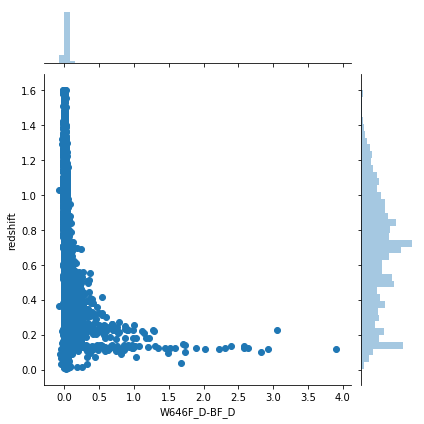

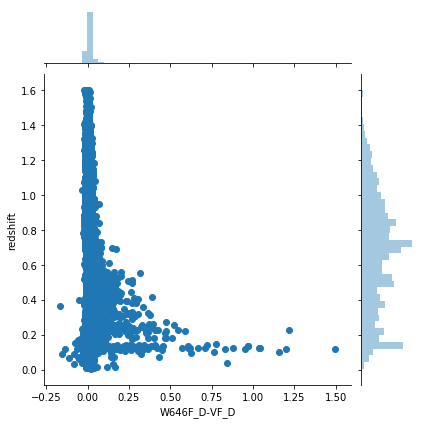

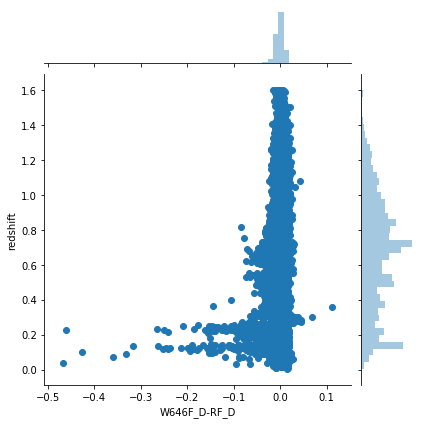

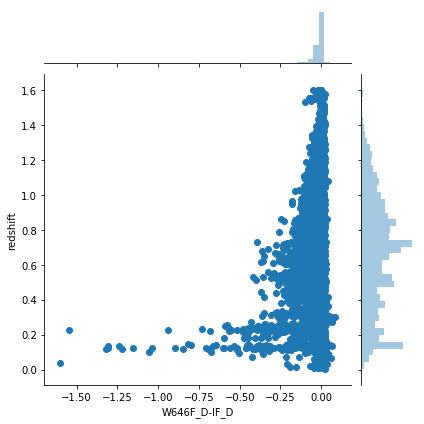

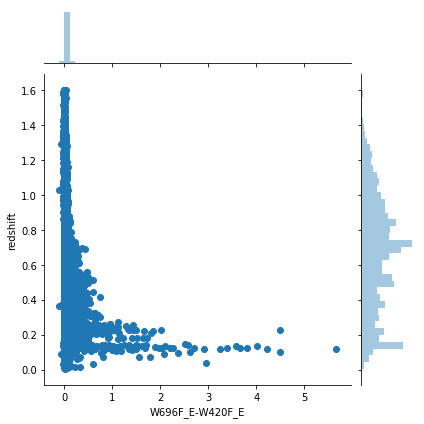

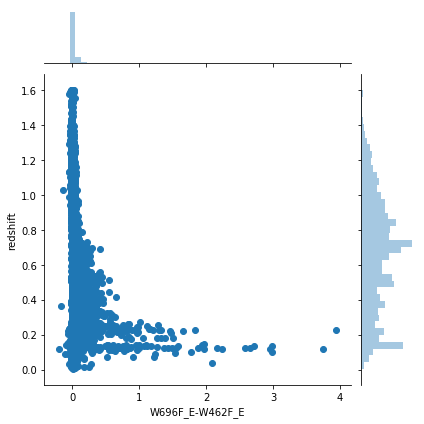

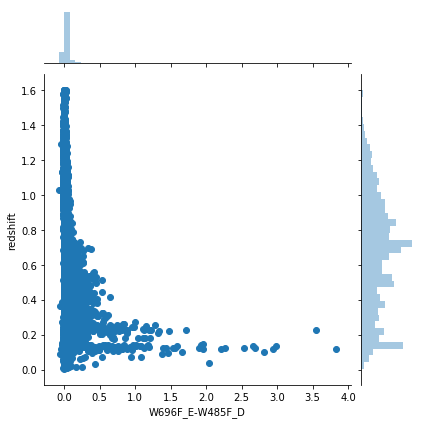

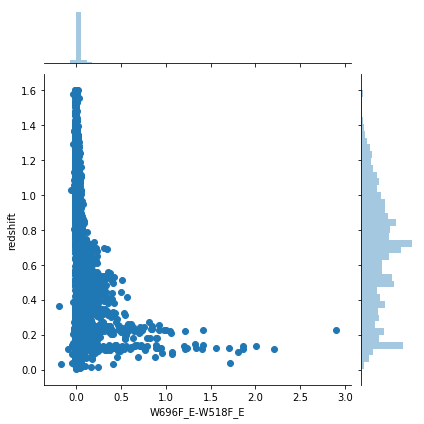

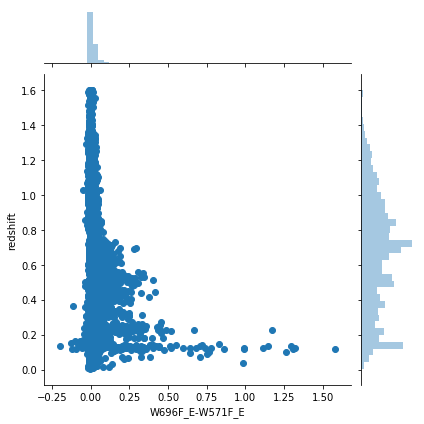

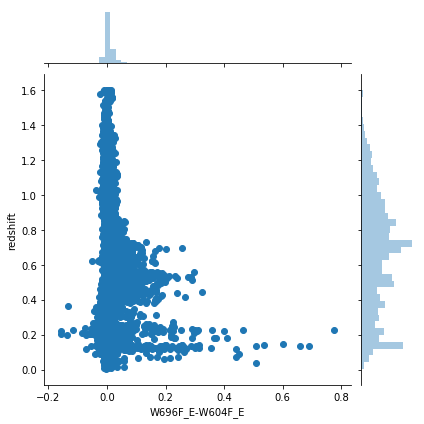

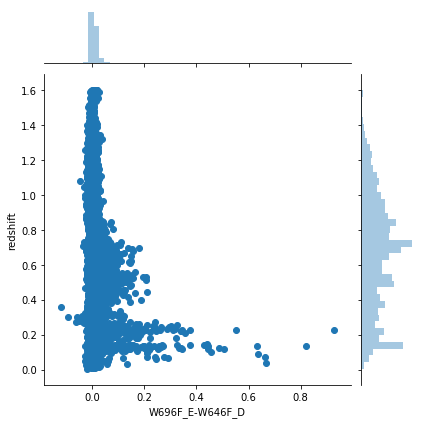

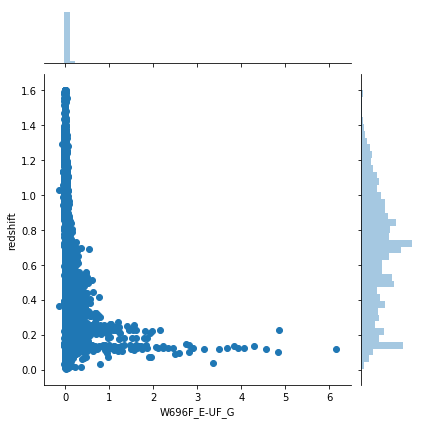

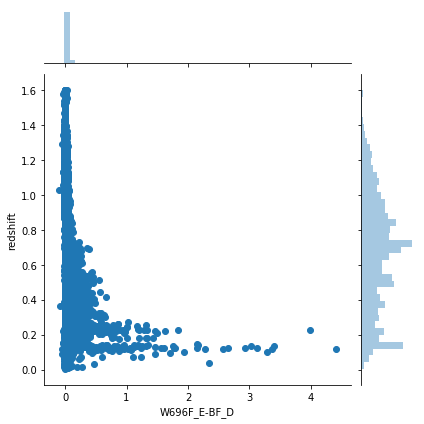

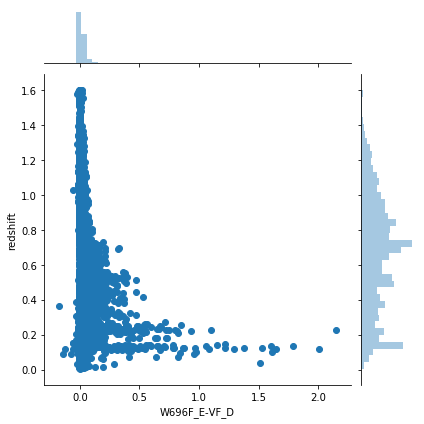

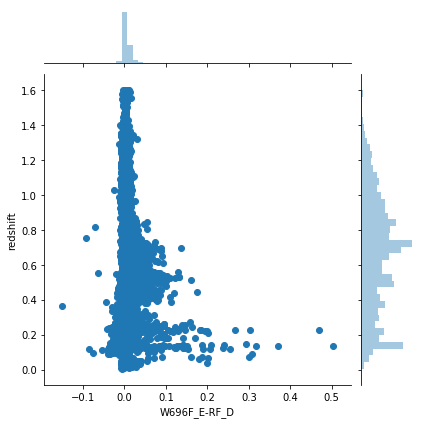

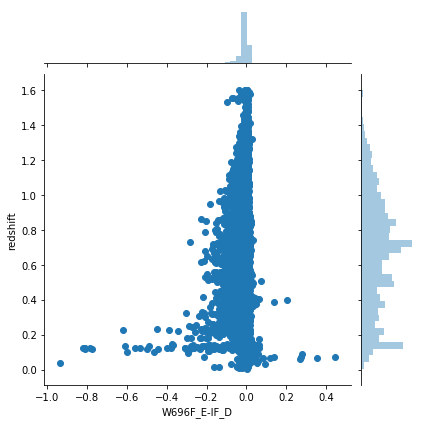

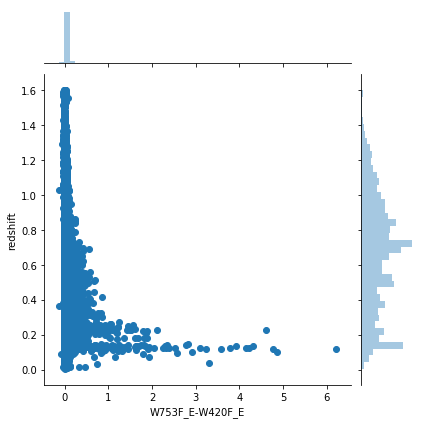

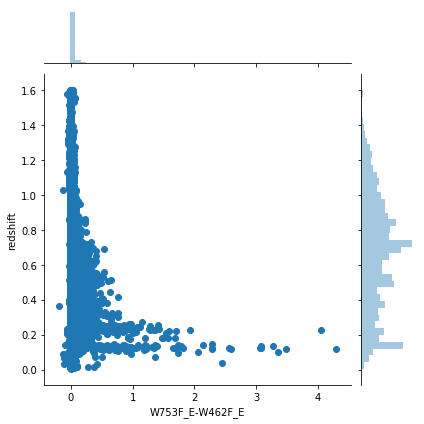

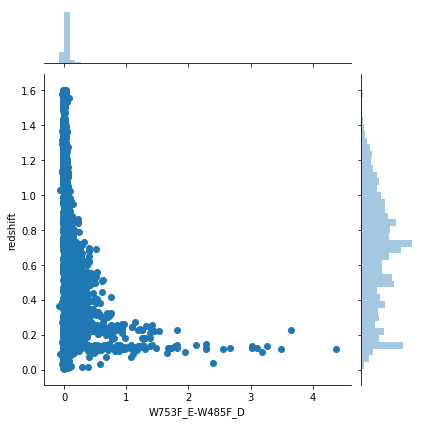

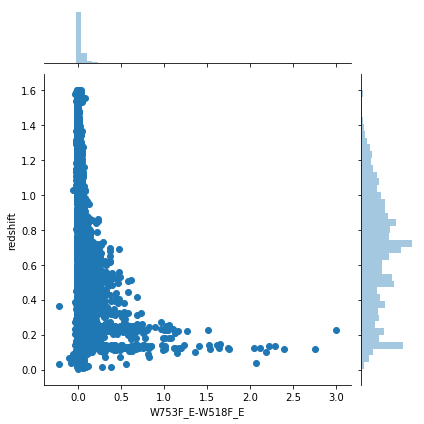

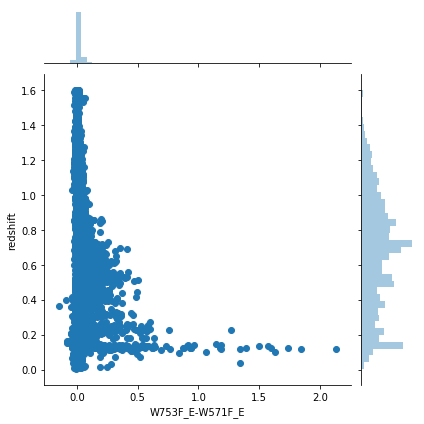

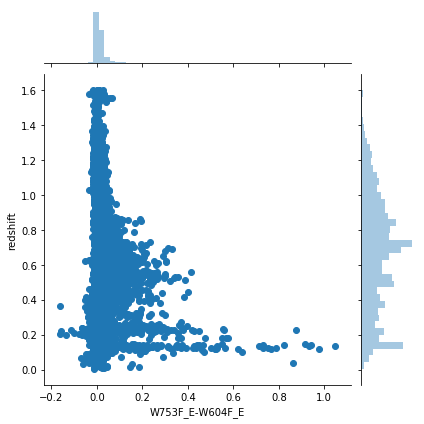

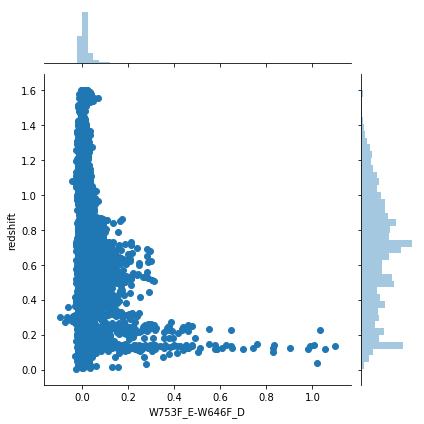

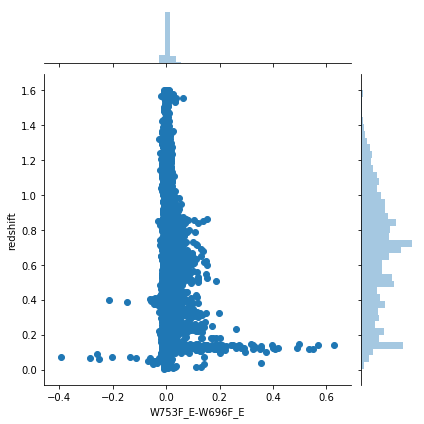

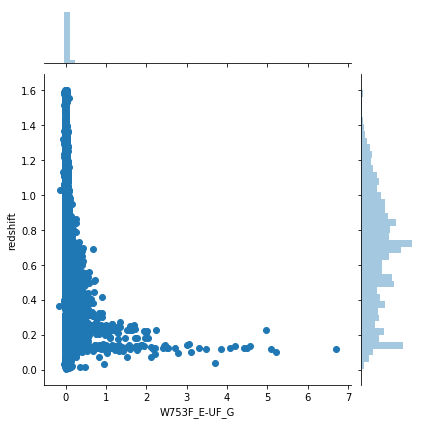

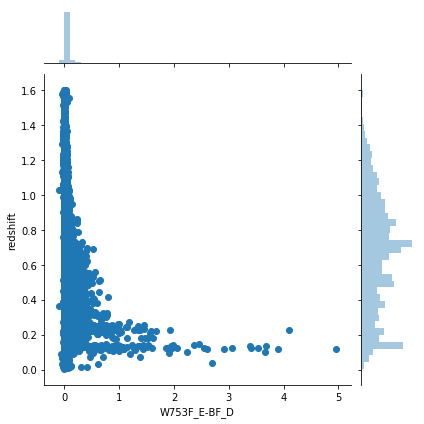

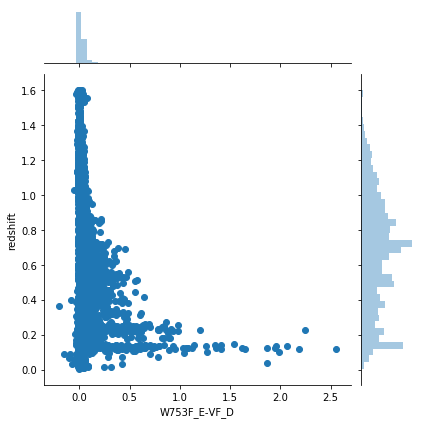

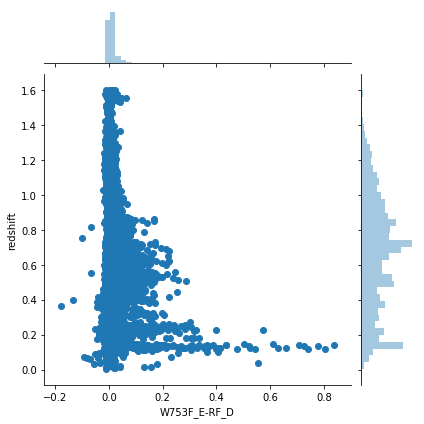

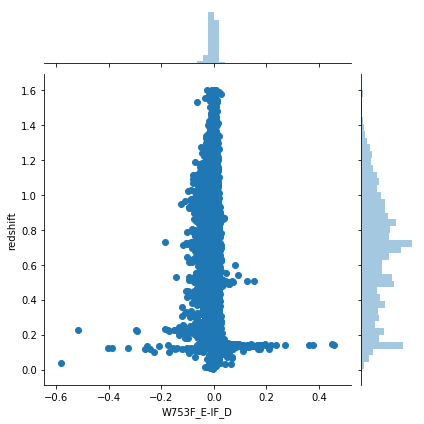

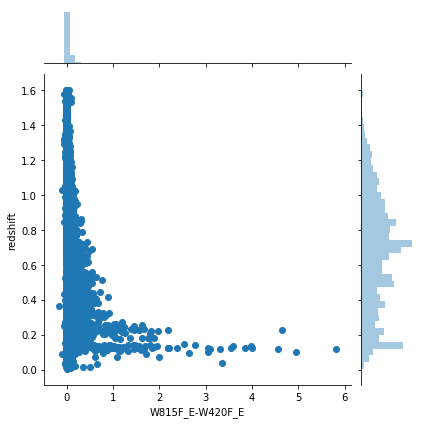

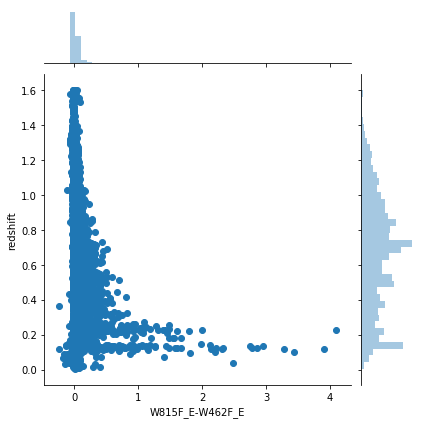

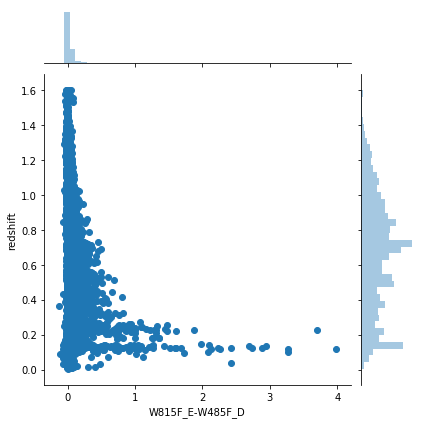

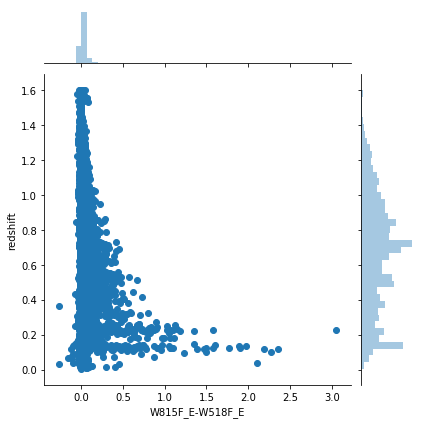

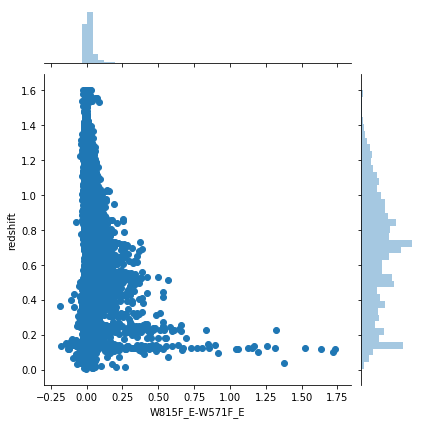

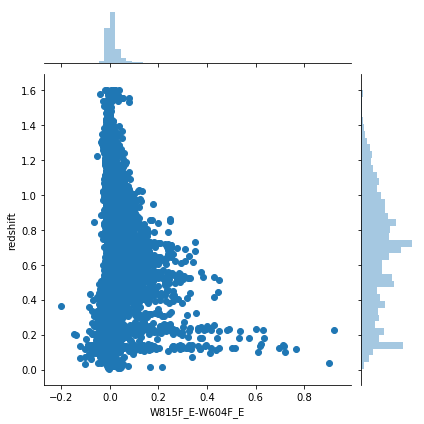

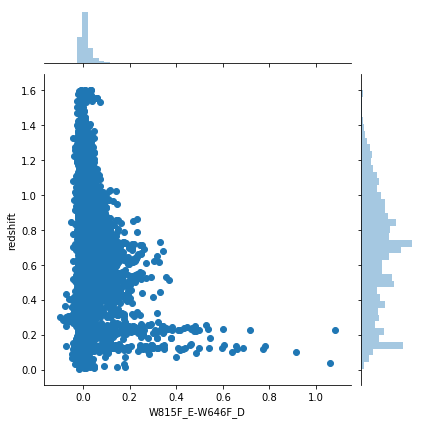

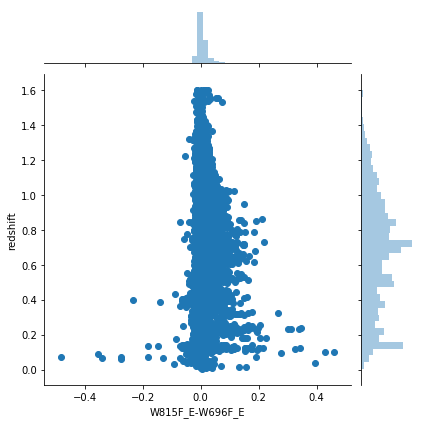

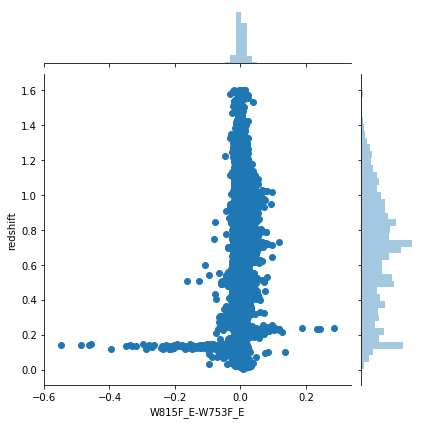

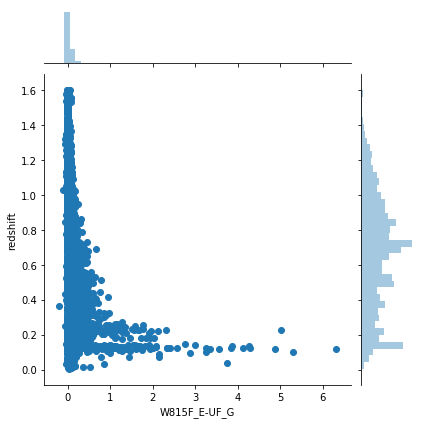

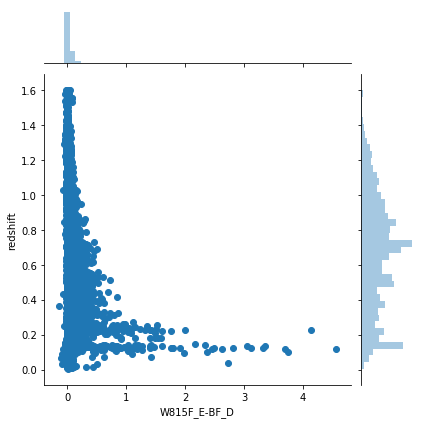

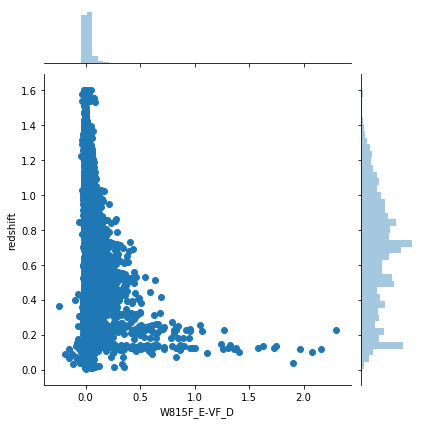

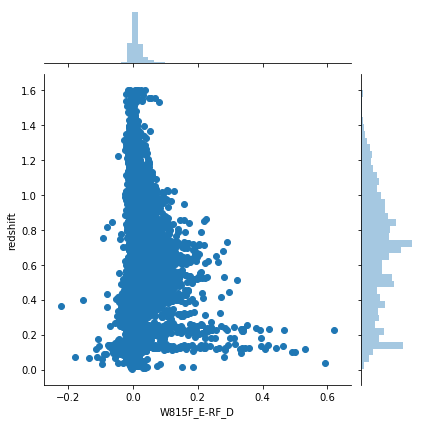

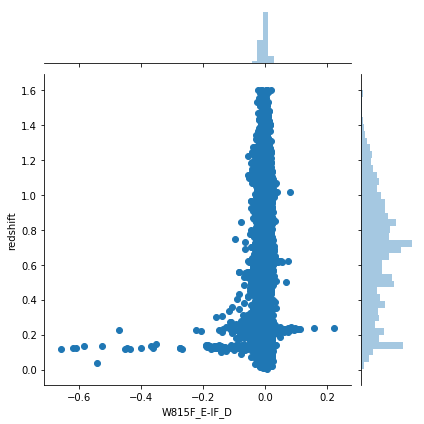

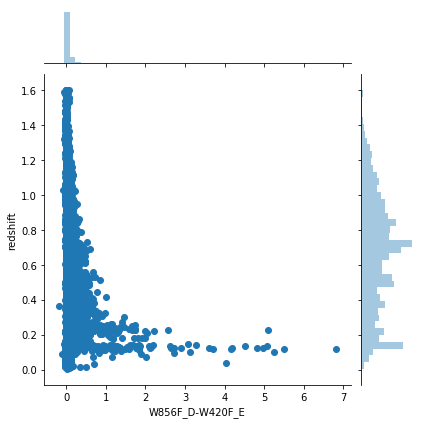

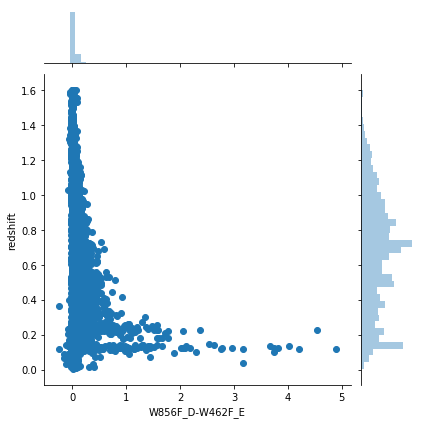

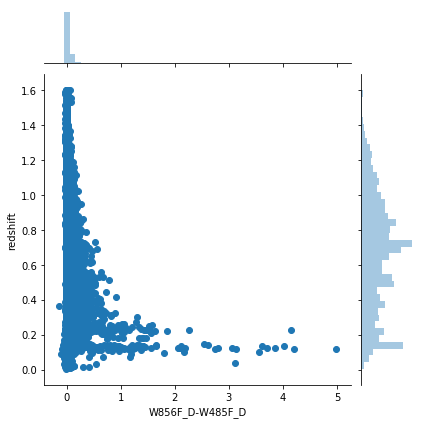

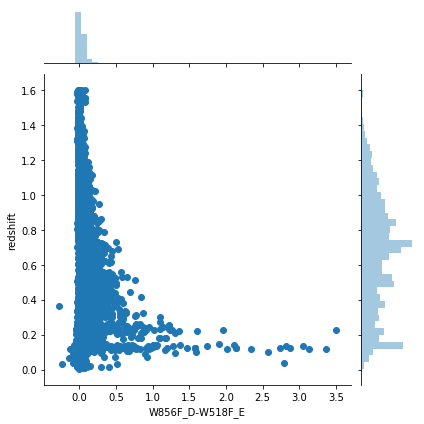

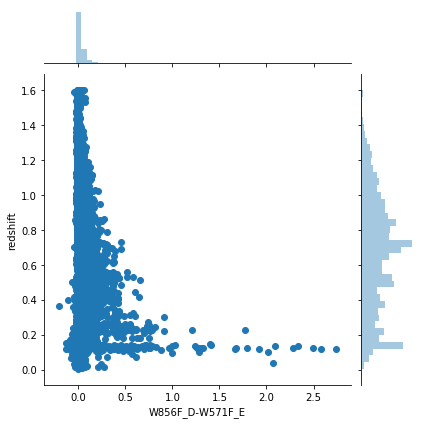

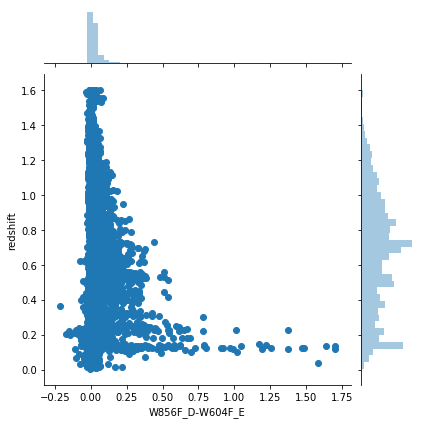

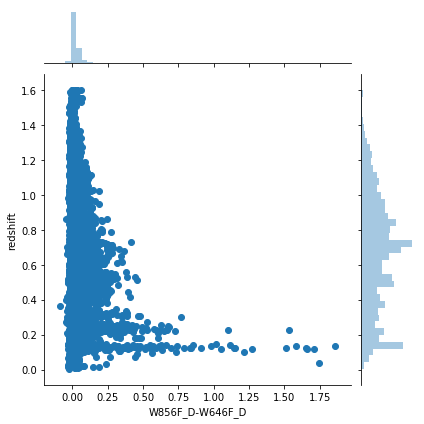

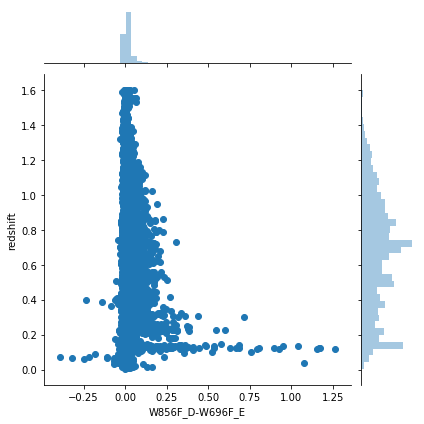

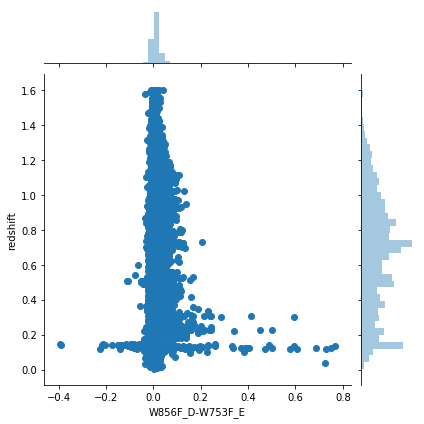

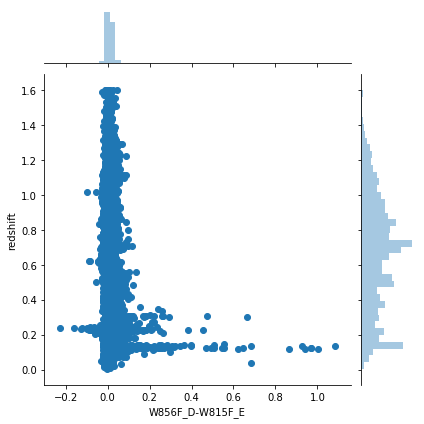

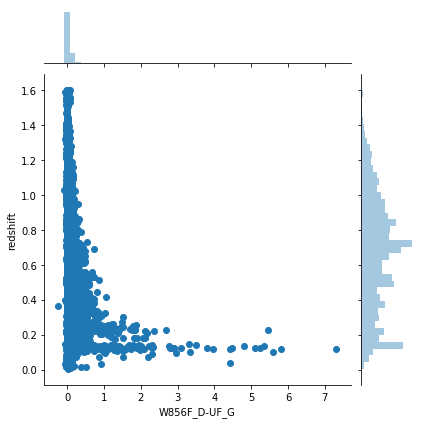

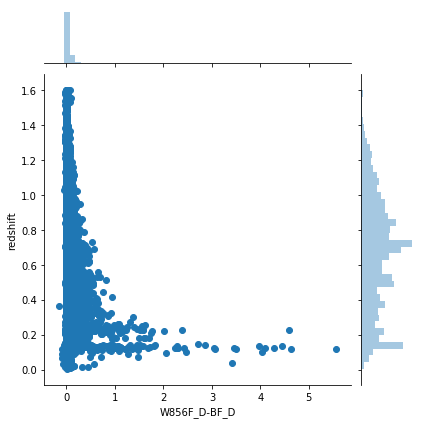

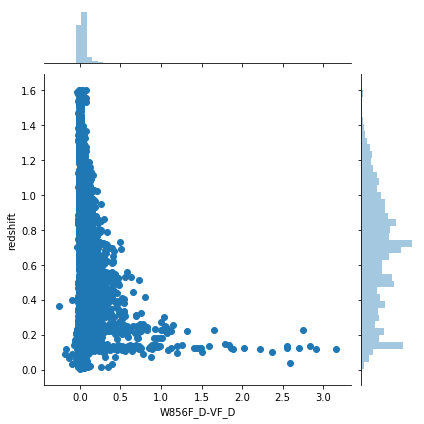

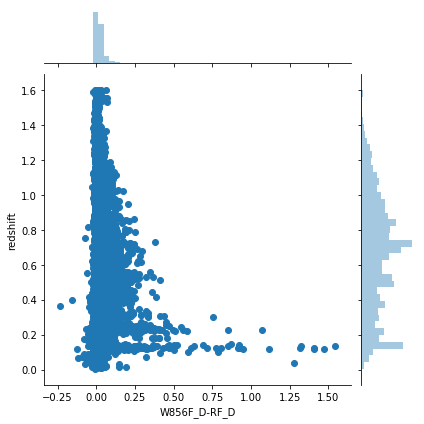

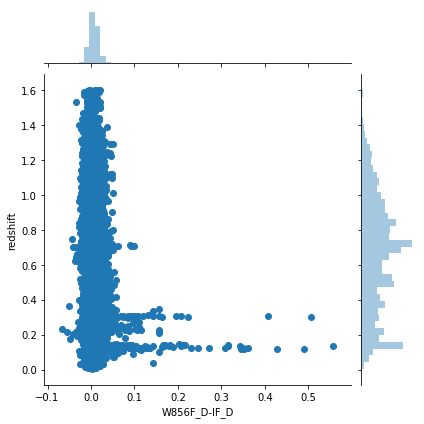

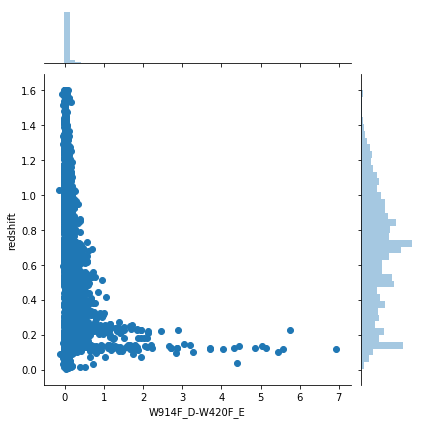

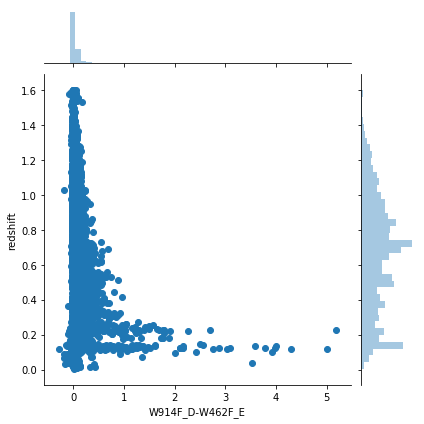

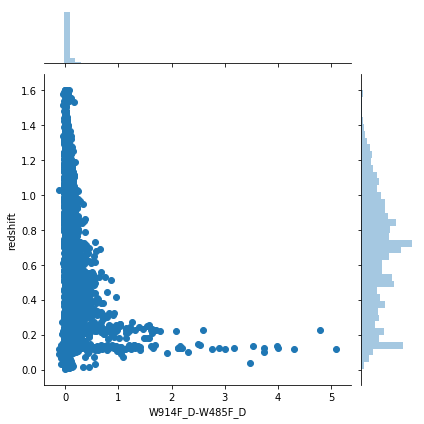

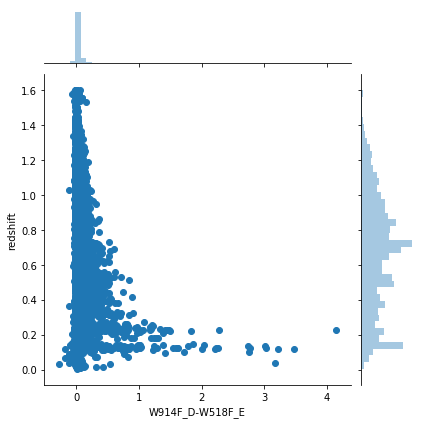

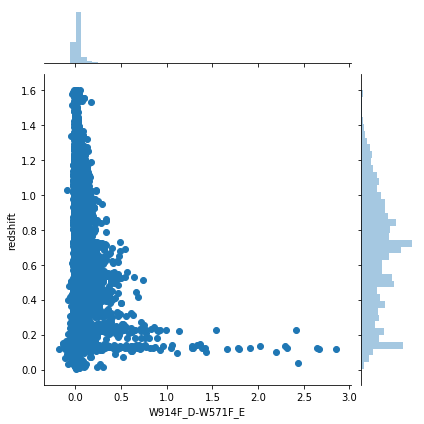

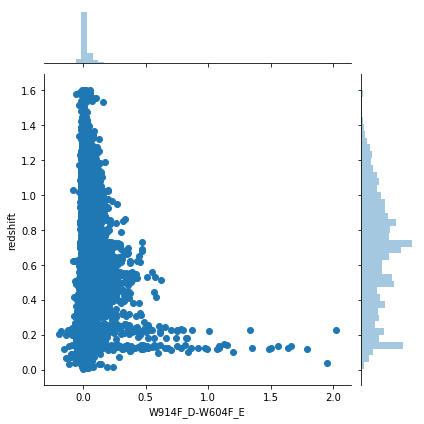

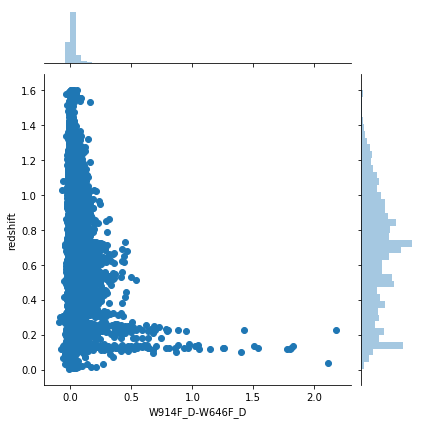

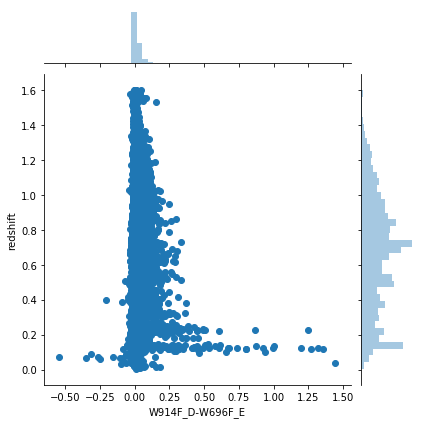

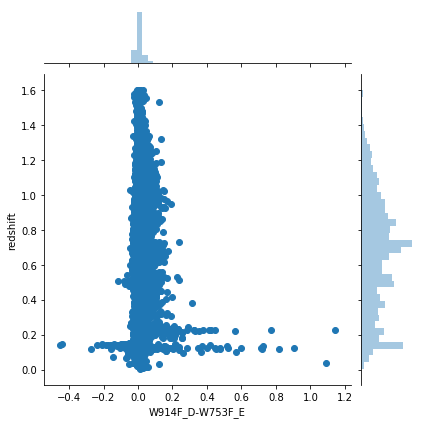

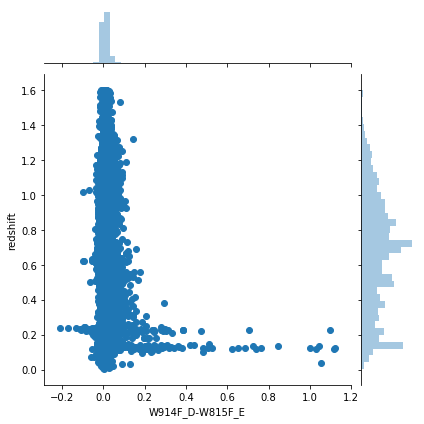

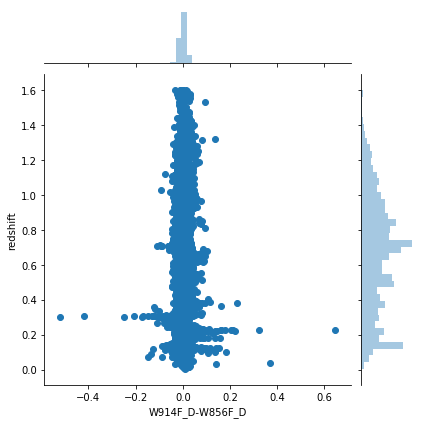

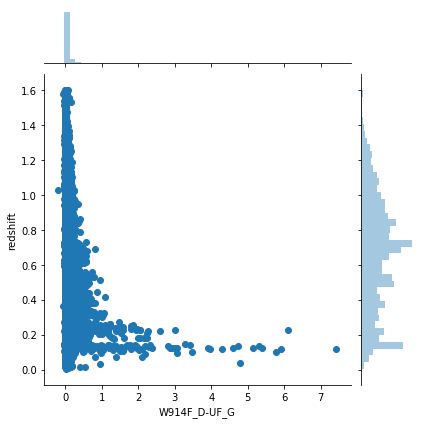

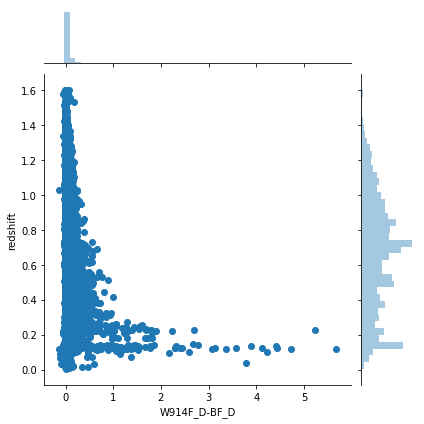

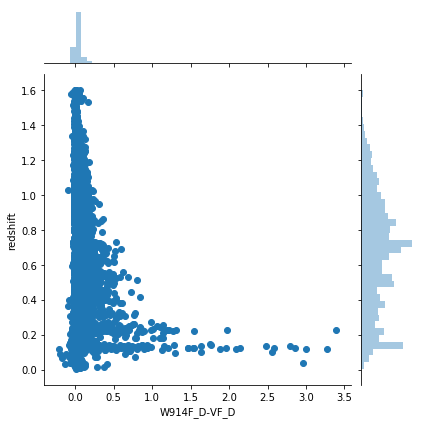

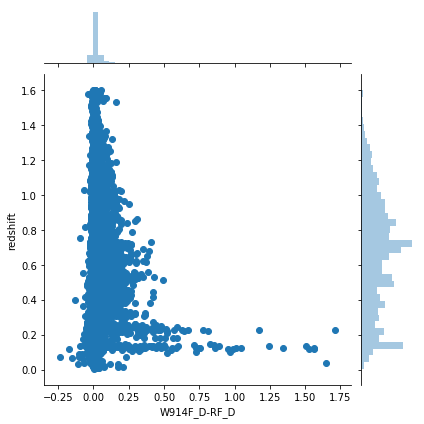

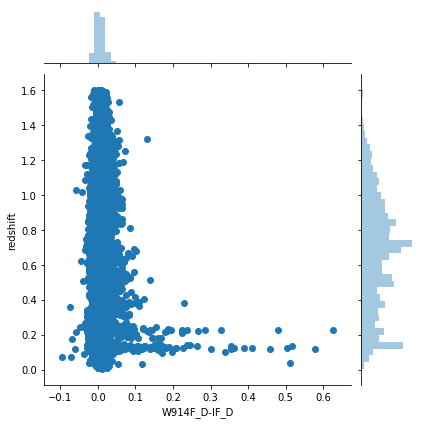

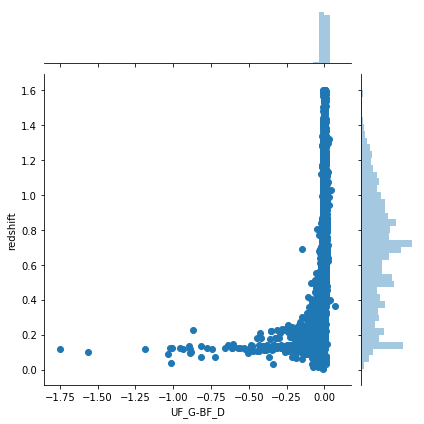

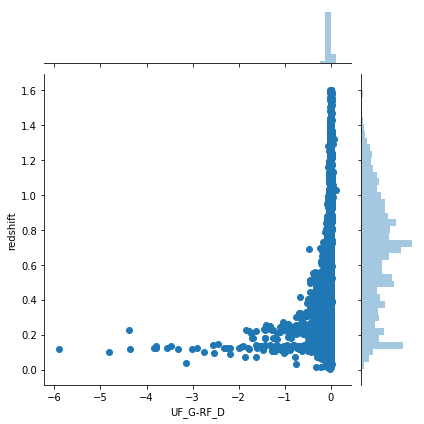

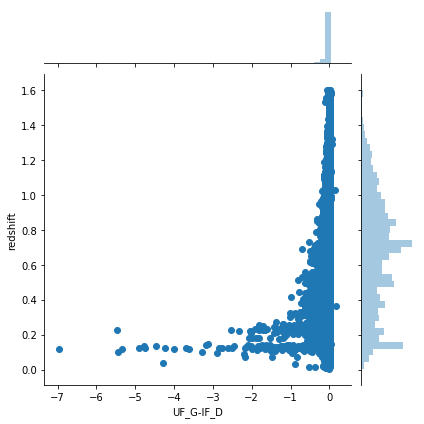

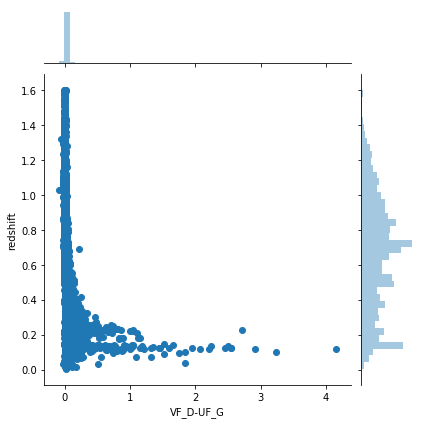

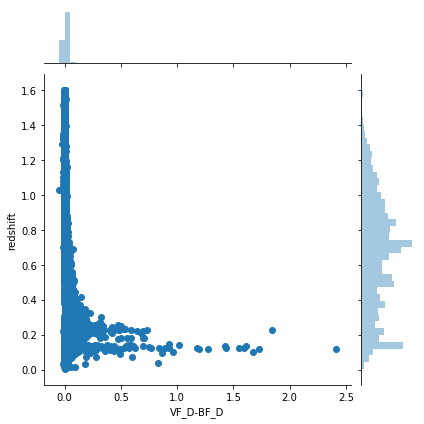

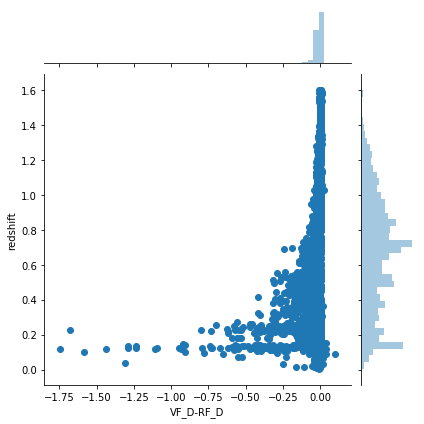

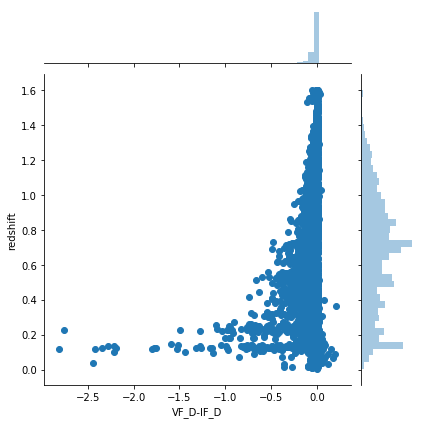

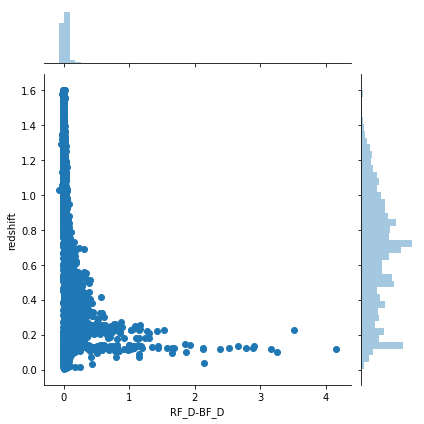

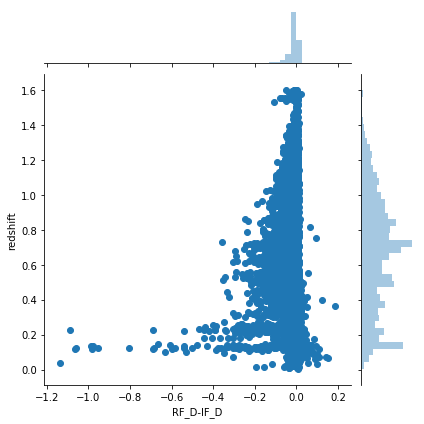

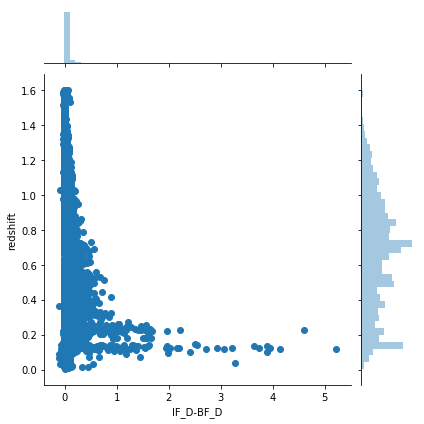

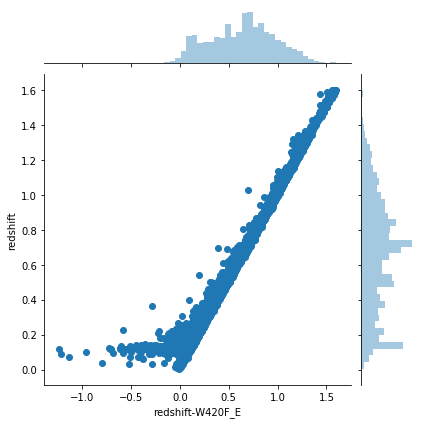

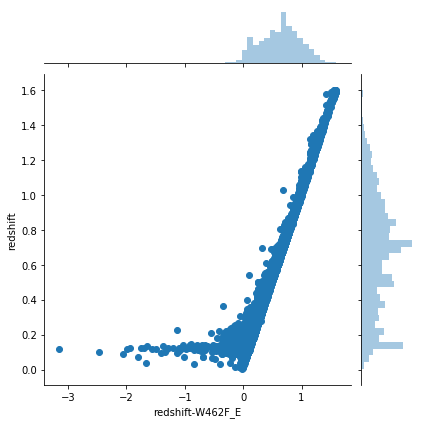

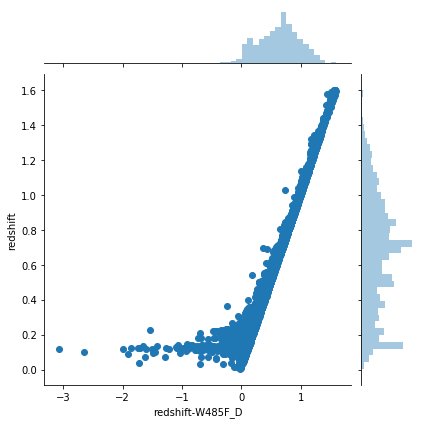

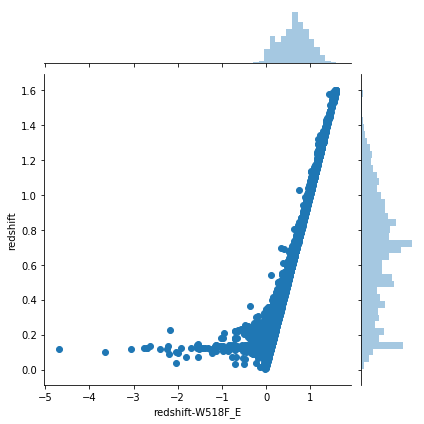

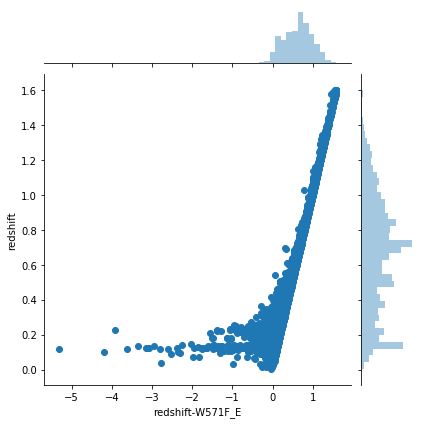

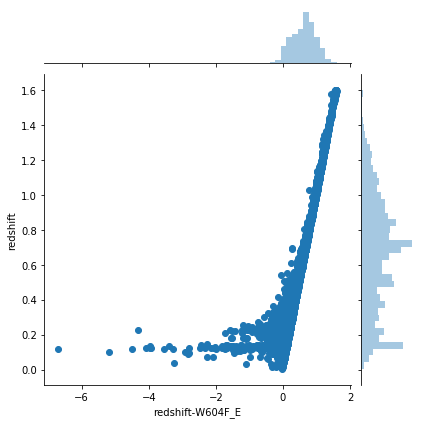

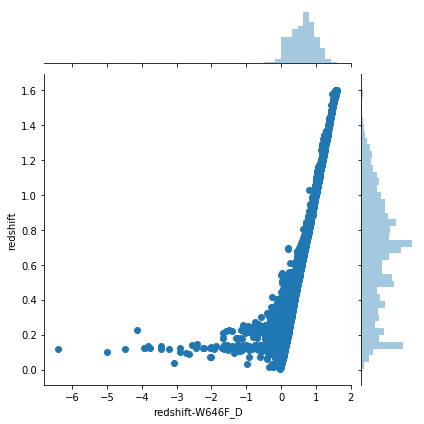

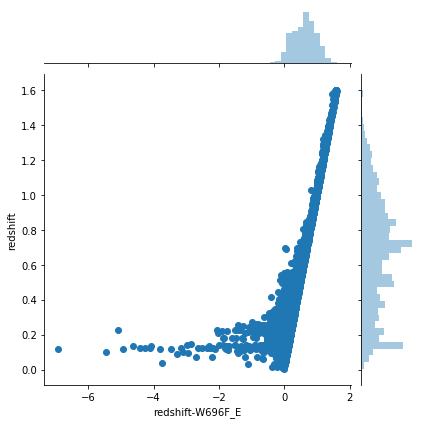

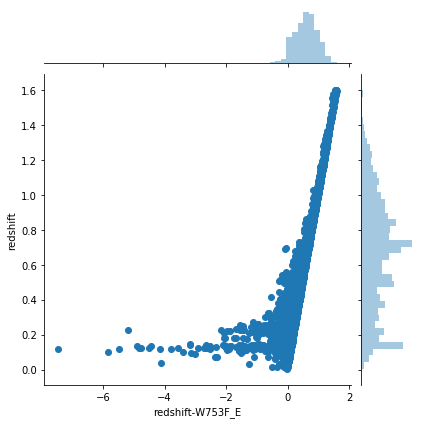

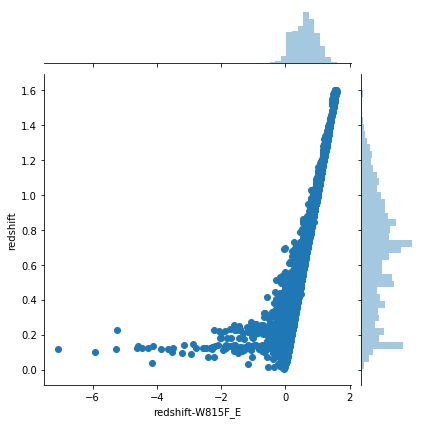

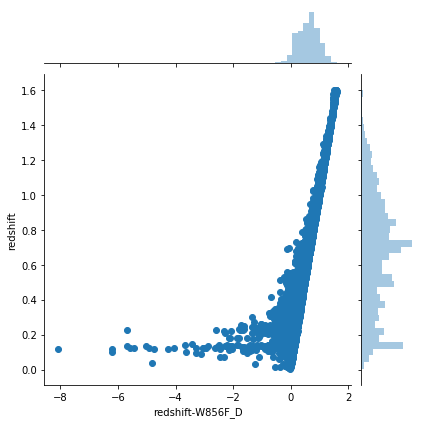

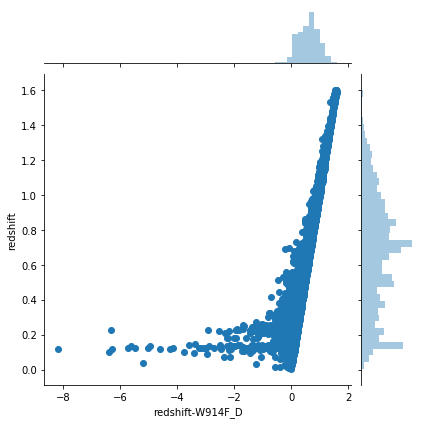

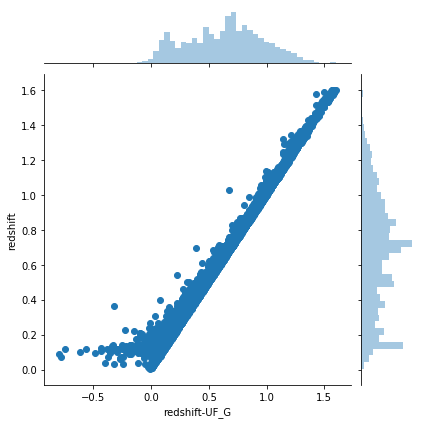

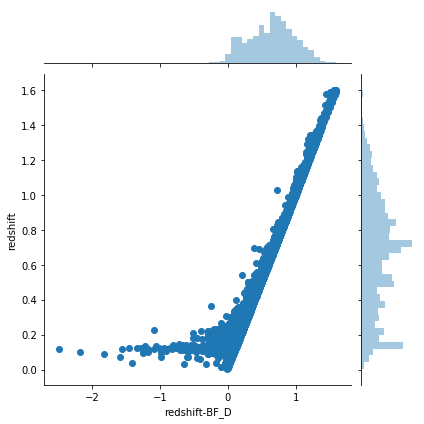

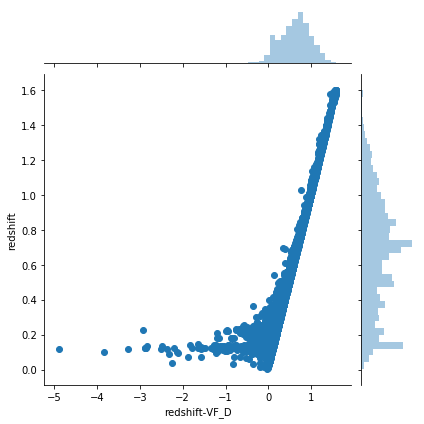

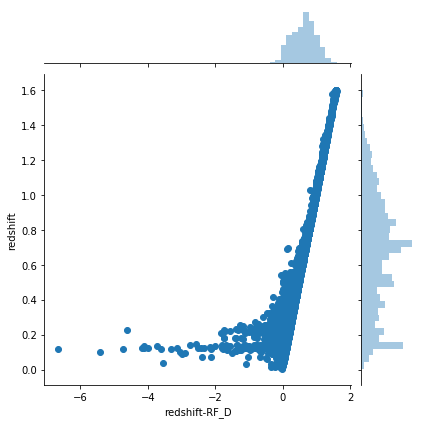

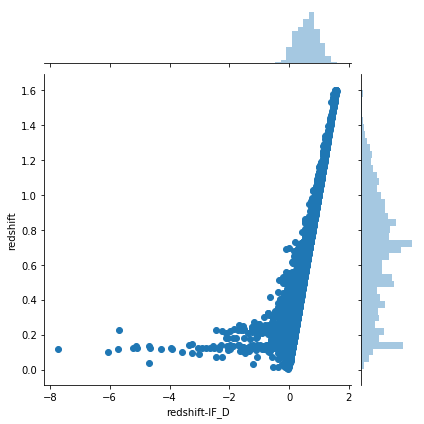

In [99]:
# look at the differences between the fluxes vs redshifts
fluxDiffs = pd.DataFrame()
fluxDiffs['redshift'] = redshift['MC_z']
for column in flux:
    for column2 in flux:
        if (column > column2):
            fluxDiffs[column + '-' + column2] = flux[column] - flux[column2]
            
for column in fluxDiffs:
    if column != 'redshift':
        sns.jointplot(x=column,y='redshift',data=fluxDiffs)    
        plt.show()

Overall, the plots show a consistent dataset that is well cleaned and ready to be used in a model. The fractional errors on the magnitudes and photon fluxes show that less than 1% of the data has large errors. I believe that this can be taken into account in a model without compromising the predicted reshifts. 

The magnitudes have the largest correlation to the redshifts, and the shape of the magnitude vs. redshift curves could prove to be helpful. The shape of the photon flux vs. redshift curves suggests that the photon fluxes will be most helpful in classifying low redshift targets. Its influence on the model should not be discounted entirely because of this even though the plots imply that it will be the least helpful above approximately redshift 0.6. 

The most important discovery from this investigation is the shape of the graphs created by the subtraction of magnitudes vs redshifts. These graphs clearly show that magnitudes do have different relationships with specific redshifts.